In [1]:
import pandas as pd
from utils import get_dfs, features_extraction_new
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
train_c

cell_id = 3

In [7]:
ue100 = pd.read_csv('data/ue_mali3_100_seed_44.csv')
cell100 = pd.read_csv('data/cell_mali3_100_seed_44.csv')
data = [ue100, cell100]
ue_test_mali = data[0]
cell_test_mali = data[1]
# normal data
ue_test_norm = pd.read_csv('data/ue_norm_seed_8.csv')
cell_test_norm = pd.read_csv('data/cell_norm_seed_8.csv')
# process
mali_dfs = get_dfs([ue_test_mali], [cell_test_mali])
norm_dfs = get_dfs([ue_test_norm], [cell_test_norm])
# extract features\
mali_dfs[0].columns
# mali_features = features_extraction_new(mali_dfs)

Index(['measPeriodPrb', 'throughput', 'DRB.UEThpDl', 'rsrp', 'rssinr', 'step',
       'nrCellIdentity', 'ue-id'],
      dtype='object')

In [7]:
from sklearn.impute import KNNImputer
def fill_missing_values(df):
    # fill null values with knn imputer not idx and step
    imputer = KNNImputer(n_neighbors=3)
    impute_df = df.drop(columns=['step', 'nrCellIdentity'])
    impute_df = pd.DataFrame(imputer.fit_transform(impute_df), columns=impute_df.columns)
    impute_df['step'] = df['step']
    impute_df['nrCellIdentity'] = df['nrCellIdentity']
    return impute_df


In [211]:
import numpy as np

v= [float('nan'), 5]
b=[float('nan')]
print(safe_len(v))

2


In [101]:
df.columns

Index(['measPeriodPrb', 'throughput', 'DRB.UEThpDl', 'rsrp', 'rssinr', 'step',
       'nrCellIdentity', 'ue-id'],
      dtype='object')

In [5]:
def features_extraction_cells(dfs):
    res = []
    
    def safe_len_set(x):
        # if {nan} return 0 else return len(x)
        if isinstance(x, set) and len(x) == 1 and  any(isinstance(item, float) and np.isnan(item) for item in x):
            return 0
        return len(x)
    
    def calculate_ue_changes(group):
        ues_by_step = group.groupby('step')['ue-id'].apply(lambda x: {ue for ue in x})
        ue_count = ues_by_step.apply(safe_len_set)
        new_ues = ues_by_step - ues_by_step.shift(1)
        left_ues = ues_by_step.shift(1) - ues_by_step
        # replace NaNs with empty sets
        new_ues = new_ues.fillna("")   
        left_ues = left_ues.fillna("")
        
        res = pd.DataFrame({
            'ue_count': ue_count,
            'new_ue_count': new_ues.apply(safe_len_set),
            'left_ue_count': left_ues.apply(safe_len_set)
        })
        # print(res)
        return res    
    # Perform the aggregations
    
    for df_a in dfs:
        cells = []
        for cid in range(1, 7):
            df = df_a[df_a['nrCellIdentity'] == cid]
            result = df.groupby(['nrCellIdentity', 'step']).agg({
                'DRB.UEThpDl': ['mean', 'std'],
                'rsrp': ['mean', 'std'],
                'rssinr': ['mean', 'std'],
                'ue-id': lambda x: list(x),  # We'll use this to calculate UE changes
                'measPeriodPrb': 'first',  # Keep the first value for each group
                'throughput': 'first'  # Keep the first value for each group
            })
             
            # Flatten the column names
            result.columns = ['_'.join(col).strip() for col in result.columns.values]
            
            # Calculate UE changes
            ue_changes = df.groupby('nrCellIdentity').apply(calculate_ue_changes).reset_index()
            
            # Rename the columns
            ue_changes = ue_changes.rename(columns={'level_1': 'step'})
            
            # Merge the results
            final_result = pd.merge(result.reset_index(), ue_changes, on=['nrCellIdentity', 'step'])
            
            # Clean up the columns
            final_result = final_result.drop('ue-id_<lambda>', axis=1)
            final_result = fill_missing_values(final_result)
            
            # Rename the new columns to remove the '_first' suffix
            final_result = final_result.rename(columns={
                'measPeriodPrb_first': 'measPeriodPrb',
                'throughput_first': 'throughput'
            })
            cells.append(final_result)
        cells_cat = pd.concat(cells)
        res.append(cells_cat)
    # sort every df in res first by step and then by cell id
    for i in range(len(res)):
        res[i] = res[i].sort_values(by=['step', 'nrCellIdentity'])
    return res

# ues, cells = load_csvs()
# dfs = get_dfs(ues, cells)
# try2 = features_extraction_cells([dfs[2]])


IndexError: string index out of range

In [169]:
import matplotlib.pyplot as plt
def plot_data(df, cell_id, name=""):
    cell_id = int(cell_id)
    df = df[df['nrCellIdentity'] == cell_id]
    df = df.drop(columns=['step', 'nrCellIdentity'])  # , 'idx'])
    df.plot(subplots=True, figsize=(10, 10), title=f'Cell {cell_id} data df {name}')
    plt.show()

In [2]:
def load_csvs(test=False):
    def fix_ues_steps(df):
        fix_ = []
        for i in range(len(df['step'].unique())):
            fix_ += [i] * 50
        df['step'] = fix_
        return df
    
    ue0 = pd.read_csv('data/ue.csv')
    cell0 = pd.read_csv('data/cell.csv')
    fix_steps = []
    for i in range(60):
        fix_steps += [i, i, i, i, i, i]
    cell0['step'] = fix_steps

    ue3 = pd.read_csv('data/ue_norm_seed_3.csv')
    cell3 = pd.read_csv('data/cell_norm_seed_3.csv')

    ue4 = pd.read_csv('data/ue_norm_seed_4.csv')
    cell4 = pd.read_csv('data/cell_norm_seed_4.csv')

    ue5 = pd.read_csv('data/ue_norm_seed_5.csv')
    cell5 = pd.read_csv('data/cell_norm_seed_5.csv')

    ue6 = pd.read_csv('data/ue_norm_seed_6.csv')
    cell6 = pd.read_csv('data/cell_norm_seed_6.csv')

    ue7 = pd.read_csv('data/ue_norm_seed_7.csv')
    cell7 = pd.read_csv('data/cell_norm_seed_7.csv')
    
    ue70_42 = pd.read_csv('data/ue_norm70_seed_42.csv')
    cell70_42 = pd.read_csv('data/cell_norm70_seed_42.csv')
    
    ue70_43 = pd.read_csv('data/ue_norm70_seed_43.csv')
    cell70_43 = pd.read_csv('data/cell_norm70_seed_43.csv')
    ue70_43 = fix_ues_steps(ue70_43)
    
    ue100_norm44 = pd.read_csv('data/ue_norm100_seed_44.csv')
    cell100_norm44 = pd.read_csv('data/cell_norm100_seed_44.csv')
    ue100_norm44 = fix_ues_steps(ue100_norm44)
    # evaluation data
    ue8 = pd.read_csv('data/ue_norm_seed_8.csv')
    cell8 = pd.read_csv('data/cell_norm_seed_8.csv')

    fix_steps = []
    for i in range(62):
        fix_steps += [i] * 50

    ue_m = pd.read_csv('data/ue_mali5_2805.csv')
    cell_m = pd.read_csv('data/cell_mali5_2805.csv')
    ue_m['step'] = fix_steps


    ue70 = pd.read_csv('data/ue_norm70_seed_42.csv')
    cell70 = pd.read_csv('data/cell_norm70_seed_42.csv')
    
    
    ues = [ue70, ue0, ue3, ue4, ue5, ue6, ue7, ue70_42, ue70_43, ue100_norm44]
    cells = [cell70, cell0, cell3, cell4, cell5, cell6, cell7, cell70_42, cell70_43, cell100_norm44]

    if test:
        ues = [ue8, ue_m]
        cells = [cell8, cell_m]

    for i in range(len(ues)):
        ues[i]['ue-id'] = ues[i]['ue-id'].apply(lambda x: int(x[2:]))

    return ues, cells

In [15]:
def process_cell_data(df_list, cell_id, win=3):
    # Filter data by cell_id
    filtered_dfs = [df[df['nrCellIdentity'] == cell_id] for df in df_list]
    
    lst = []
    max_steps = [df['step'].max() for df in filtered_dfs]
    max_cells = max([df['nrCellIdentity'].max() for df in filtered_dfs])
    counter = 0
    
    for s in range(max(max_steps)):    
        for j, df in enumerate(dfs):
            for w in range(win):
                if s + w > max_steps[j]:
                    continue
                try:
                    df_cell_step = df[df['step'] == s + w]
                    df_cell_step['idx'] = [int(counter)] * df_cell_step.shape[0]
                    # if cell == 5 and counter == 16:
                    #     print(f"here step: {s + w}, cell: {cell}, idx: {counter}\n{df_cell_step}")

                    lst.append(df_cell_step)
                except:
                    print("error")
                    continue
            counter += 1
    combined_df = pd.concat(lst, ignore_index=True)
    
    # Sort by step to ensure correct order
    combined_df = combined_df.sort_values('idx')
    
    # Create a new column 'idx' representing 3-step time windows
    # combined_df['idx'] = combined_df['step'] // 3
    
    return combined_df


In [16]:
# plot number of UEs in each cell over time
import numpy as np
ues, cells = load_csvs()
dfs = get_dfs(ues, cells)

feats = features_extraction_cells(dfs)


C:\Users\user\AppData\Local\Temp\ipykernel_21960\3509676752.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ue_changes = df.groupby('nrCellIdentity').apply(calculate_ue_changes).reset_index()
C:\Users\user\AppData\Local\Temp\ipykernel_21960\3509676752.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ue_changes = df.groupby('nrCellIdentity').apply(calculate_ue_changes).reset_index()
C:\Users\user\Ap

measPeriodPrb  throughput  DRB.UEThpDl       rsrp        rssinr  step  \
0                360  201.992067    25.000373 -68.185408  1.250733e+09     0   
96               448  252.349372    25.241289 -68.800855  9.458995e+01     1   
97               448  252.349372    25.439152 -59.638054  8.951589e+09     1   
98               448  252.349372    25.054654 -62.535802  4.593306e+09     1   
99               448  252.349372    25.060294 -63.136985  3.999513e+09     1   
...              ...         ...          ...        ...           ...   ...   
96787            625  355.372821    25.287745 -55.581519  2.278000e+10    95   
96786            625  355.372821    25.520051 -56.369312  1.900091e+10    95   
96785            625  355.372821    25.431948 -66.609444  1.797882e+09    95   
96795            625  355.372821    25.294046 -42.303152  4.846077e+11    95   
96860            413  225.967686    25.322778 -67.343434  1.518316e+09    96   

       nrCellIdentity  ue-id  idx  
0                   1    5.0    0  
96                  6   33.0    0  
97                  6   42.0    0  
98                  6   45.0    0  
99                  6   49.0    0  
...               ...    ...  ...  
96787               4   17.0  959  
96786               4   16.0  959  
96785               4    2.0  959  
96795               4   42.0  959  
96860               6   46.0  959  

[96861 rows x 9 columns]

In [32]:
window_size = 3
d = pd.concat(feats)
d = d.sort_values(['step'])
d = d[d['nrCellIdentity'] == 1]
d['idx_t'] = range(d.shape[0])


new = []
x = 0
for i in range(max(d['idx_t'])):
    temp = []
    for j in range(x, x+window_size):
        current = d[d['idx_t'] == j]
        current['idx'] = x
        temp.append(current)  
    x += 1
    new.append(pd.concat(temp))

new = pd.concat(new)
new.sort_values(['idx'], inplace=True)
new.tail()

DRB.UEThpDl_mean  DRB.UEThpDl_std  rsrp_mean   rsrp_std   rssinr_mean  \
95         25.288273         0.179274 -59.629929  10.916627  9.856153e+10   
94         25.288273         0.179274 -59.470468  11.073110  1.032319e+11   
96         25.288273         0.179274 -59.805328  10.737272  9.183252e+10   
95         25.288273         0.179274 -59.629929  10.916627  9.856153e+10   
96         25.288273         0.179274 -59.805328  10.737272  9.183252e+10   

      rssinr_std  measPeriodPrb  throughput  ue_count  new_ue_count  \
95  2.249039e+11          562.0  328.747544      13.0           0.0   
94  2.203555e+11          562.0  328.747544      13.0           0.0   
96  2.198072e+11          562.0  328.747544      13.0           0.0   
95  2.249039e+11          562.0  328.747544      13.0           0.0   
96  2.198072e+11          562.0  328.747544      13.0           0.0   

    left_ue_count  step  nrCellIdentity  idx_t  idx  
95            0.0    95               1    653  652  
94            0.0    94               1    652  652  
96            0.0    96               1    654  652  
95            0.0    95               1    653  653  
96            0.0    96               1    654  653

In [12]:
trains = [process_cell_data(dfs, cell_id=i) for i in range(1, 7)]
trains[0]

measPeriodPrb  throughput  DRB.UEThpDl       rsrp        rssinr  step  \
0               360  201.992067    25.000373 -68.185408  1.250733e+09     0   
4284            360  201.992067    25.293462 -73.056957  4.073895e+08     0   
4283            360  201.992067    25.263094 -65.626718  2.254415e+09     0   
4282            360  201.992067    25.396723 -57.597645  1.431994e+10     0   
4281            360  201.992067    25.127967 -58.934146  1.052667e+10     0   
...             ...         ...          ...        ...           ...   ...   
6863            562  328.747544    25.222276 -59.252030  9.783686e+09    96   
6862            562  328.747544    25.053447 -71.635157  5.651841e+08    96   
6873            562  328.747544    25.535774 -45.901339  2.116273e+11    96   
6867            562  328.747544    25.091919 -74.286228  3.069607e+08    96   
6874            562  328.747544    25.119283 -40.150172  7.955883e+11    96   

      nrCellIdentity  ue-id  idx  
0                  1    5.0    0  
4284               1   40.0    0  
4283               1   36.0    0  
4282               1   29.0    0  
4281               1   17.0    0  
...              ...    ...  ...  
6863               1    6.0   32  
6862               1    4.0   32  
6873               1   40.0   32  
6867               1   13.0   32  
6874               1   45.0   32  

[6875 rows x 9 columns]

In [255]:
t = feats[2]
t = t[t['nrCellIdentity'] == 2]
t

DRB.UEThpDl_mean  DRB.UEThpDl_std  rsrp_mean  rsrp_std   rssinr_mean  \
0          25.289440         0.210469 -51.647331  2.029169  6.063918e+10   
1          25.289440         0.210469 -51.931994  2.362948  5.820026e+10   
2          25.289440         0.210469 -52.243116  2.717778  5.586570e+10   
3          25.289440         0.210469 -52.581792  3.060360  5.344291e+10   
4          25.289440         0.210469 -52.948320  3.373358  5.081092e+10   
5          25.289440         0.210469 -53.342076  3.648291  4.792100e+10   
6          25.289440         0.210469 -53.761526  3.881812  4.478683e+10   
7          25.289440         0.210469 -54.204334  4.073720  4.146757e+10   
8          25.289440         0.210469 -54.667551  4.225797  3.804827e+10   
9          25.289440         0.210469 -55.147833  4.341045  3.462156e+10   
10         25.289440         0.210469 -55.641671  4.423151  3.127366e+10   
11         25.289440         0.210469 -56.145577  4.476094  2.807550e+10   
12         25.289440         0.210469 -56.656242  4.503876  2.507886e+10   
13         25.289440         0.210469 -57.170642  4.510325  2.231622e+10   
14         25.289440         0.210469 -57.686099  4.498978  1.980309e+10   
15         25.289440         0.210469 -58.200305  4.473017  1.754141e+10   
16         25.289440         0.210469 -58.711323  4.435242  1.552323e+10   
17         25.289440         0.210469 -59.217565  4.388074  1.373404e+10   
18         25.289440         0.210469 -59.717759  4.333577  1.215554e+10   
19         25.289440         0.210469 -61.479704  3.699073  7.906360e+09   
20         25.289440         0.210469 -61.939556  3.650407  7.057640e+09   
21         25.289440         0.210469 -62.390754  3.598054  6.309035e+09   
22         25.289440         0.210469 -62.833174  3.543029  5.649188e+09   
23         25.289440         0.210469 -63.266779  3.486166  5.067610e+09   
24         25.289440         0.210469 -63.691593  3.428148  4.554785e+09   
25         25.239074         0.308973 -61.985976  3.677217  6.175858e+09   
26         25.239074         0.308973 -62.428118  3.609401  5.545377e+09   
27         25.020597         0.210469 -60.357497  3.649178  7.585005e+09   
28         25.020597         0.243304 -60.830343  3.641893  6.802542e+09   
29         25.020597         0.243304 -61.294260  3.606100  6.113354e+09   
30         25.020597         0.243304 -61.749173  3.546198  5.505392e+09   
31         25.020597         0.243304 -62.195081  3.507905  4.968182e+09   
32         25.020597         0.243304 -62.632038  3.507905  4.492641e+09   
33         25.020597         0.243304 -63.060144  3.507905  4.070907e+09   
34         25.020597         0.243304 -63.479533  3.507905  3.696172e+09   
35         25.020597         0.243304 -63.890365  3.507905  3.362552e+09   
36         25.020597         0.243304 -67.901457  3.507905  1.335242e+09   
37         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
38         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
39         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
40         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
41         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
42         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
43         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
44         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
45         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
46         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
47         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
48         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
49         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
50         25.289440         0.210469 -51.940814  2.369965  5.823505e+10   
51         25.289440         0.210469 -51.940814  2.

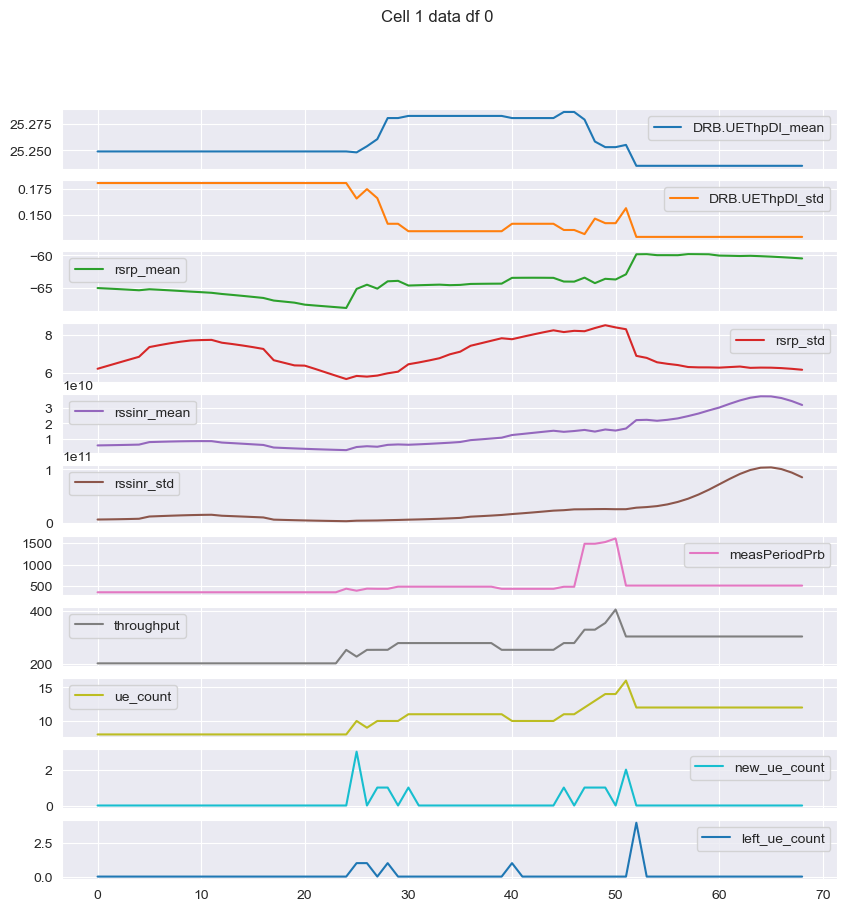

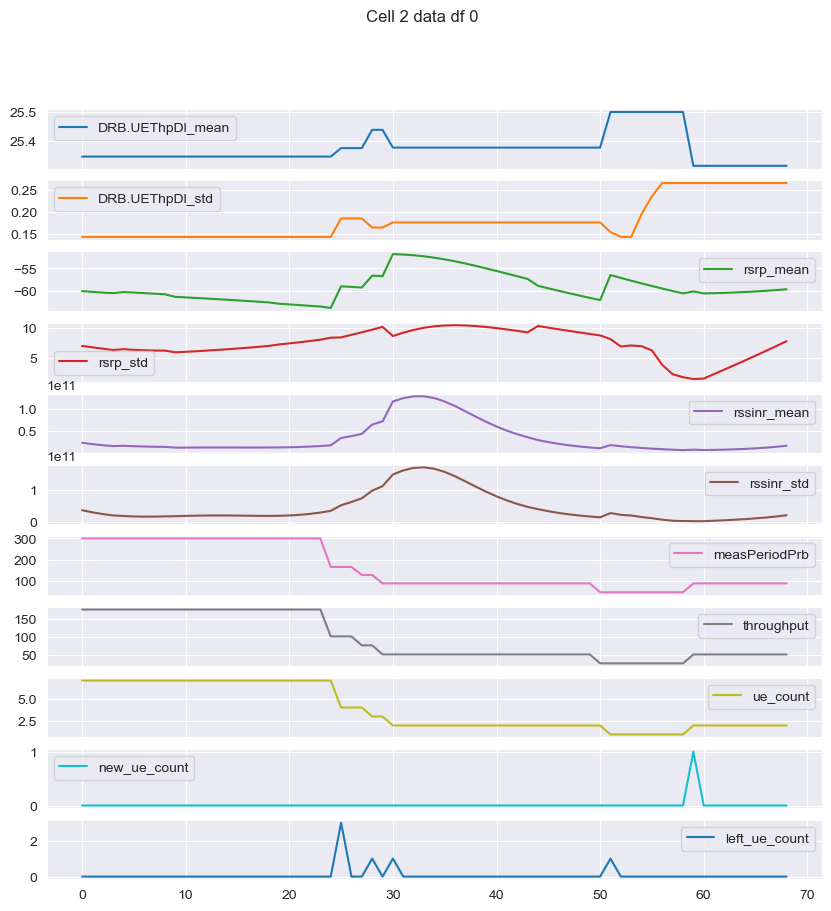

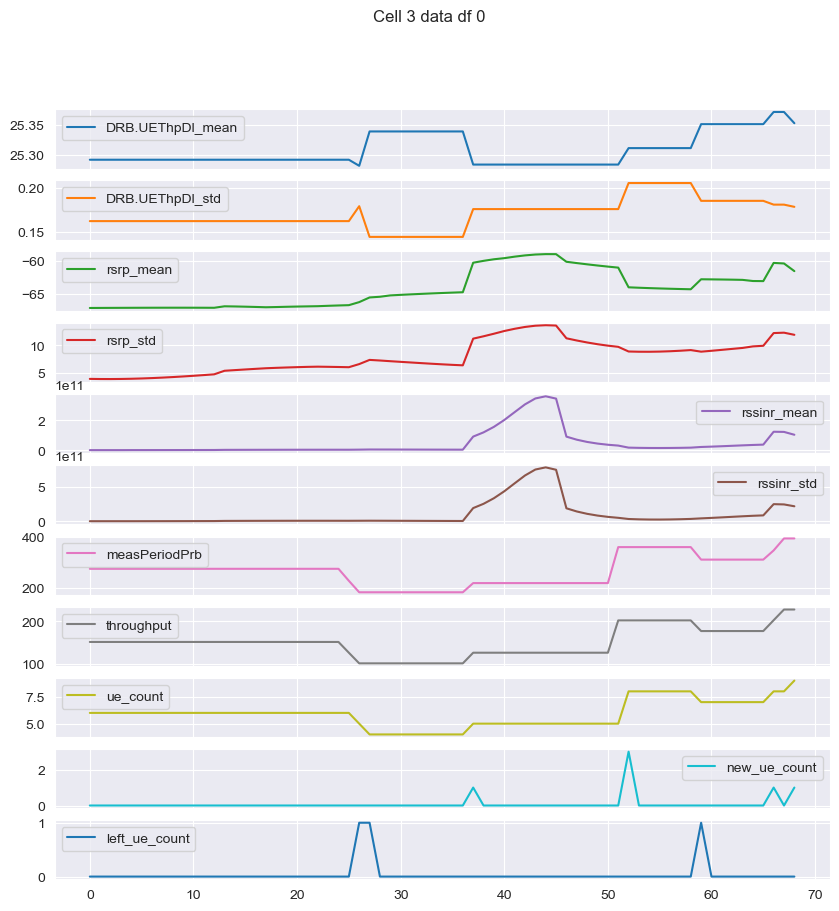

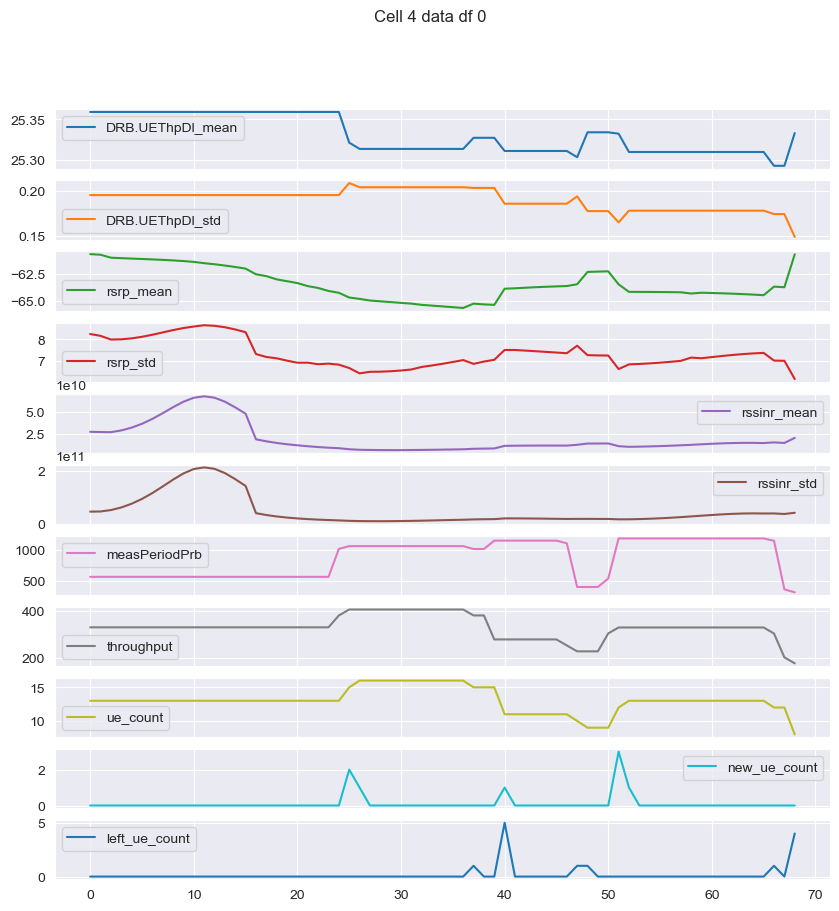

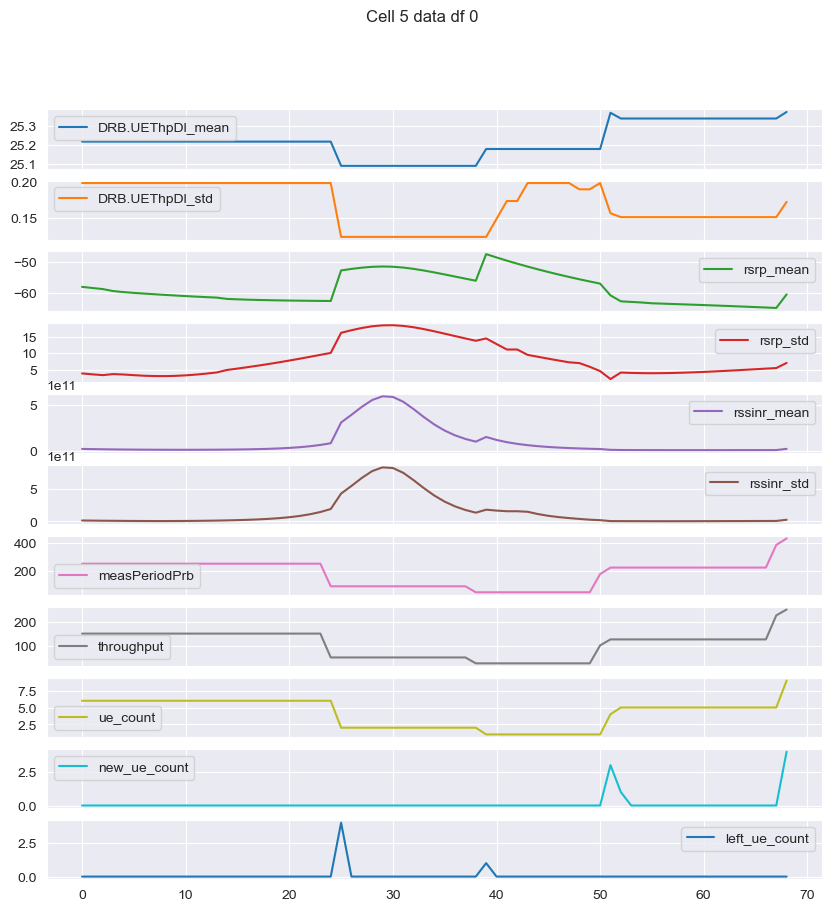

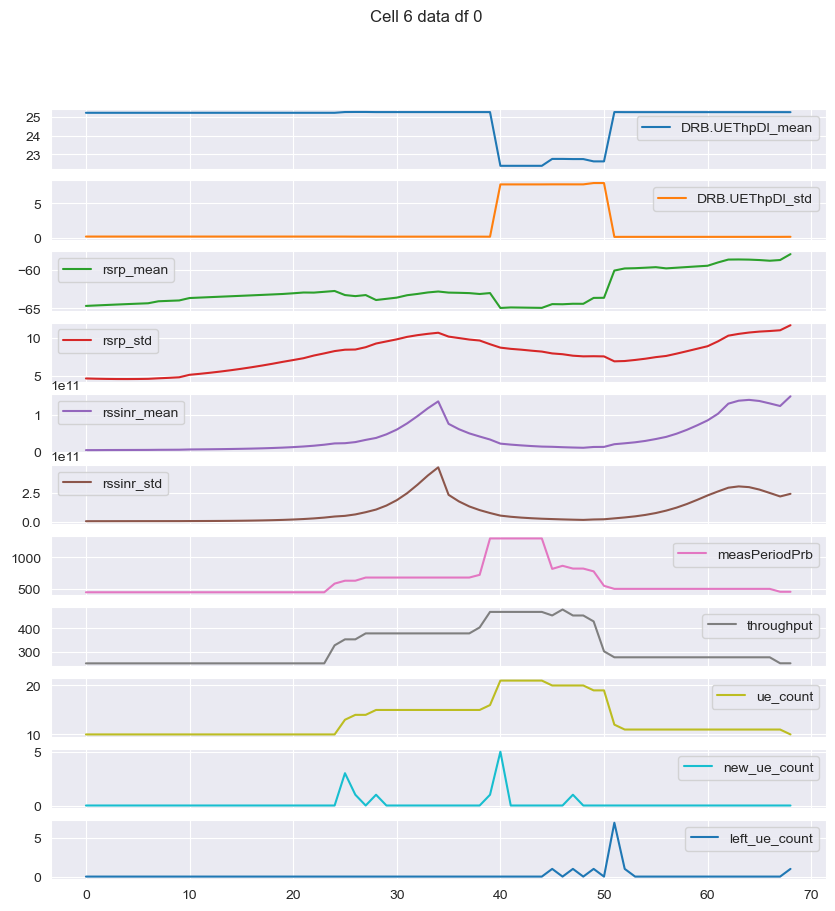

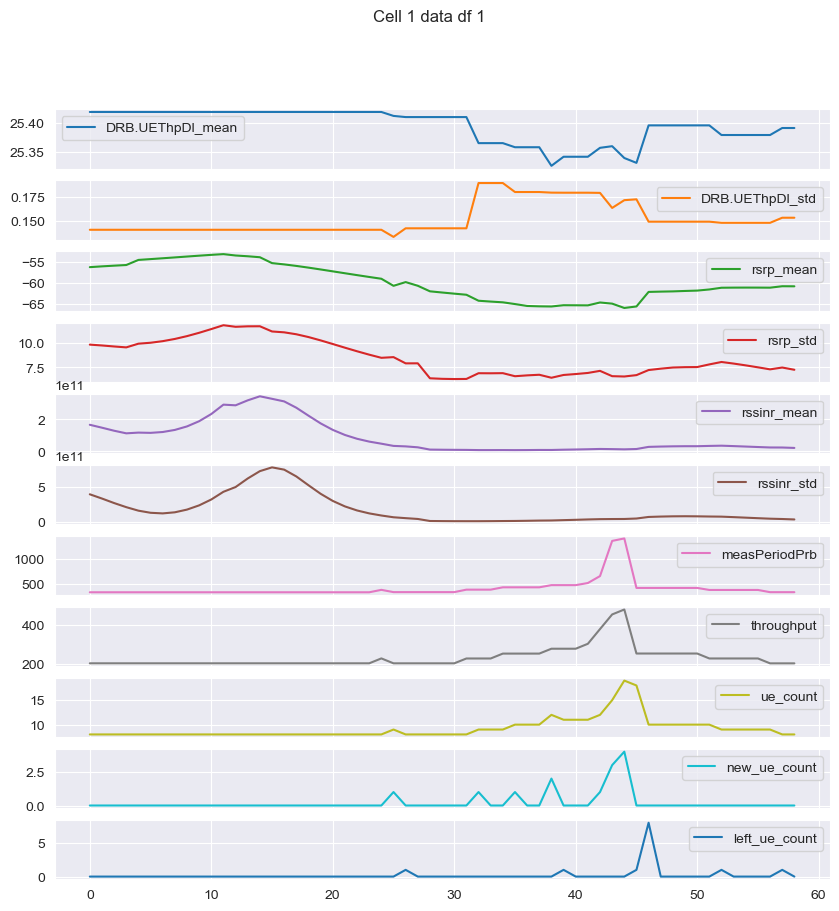

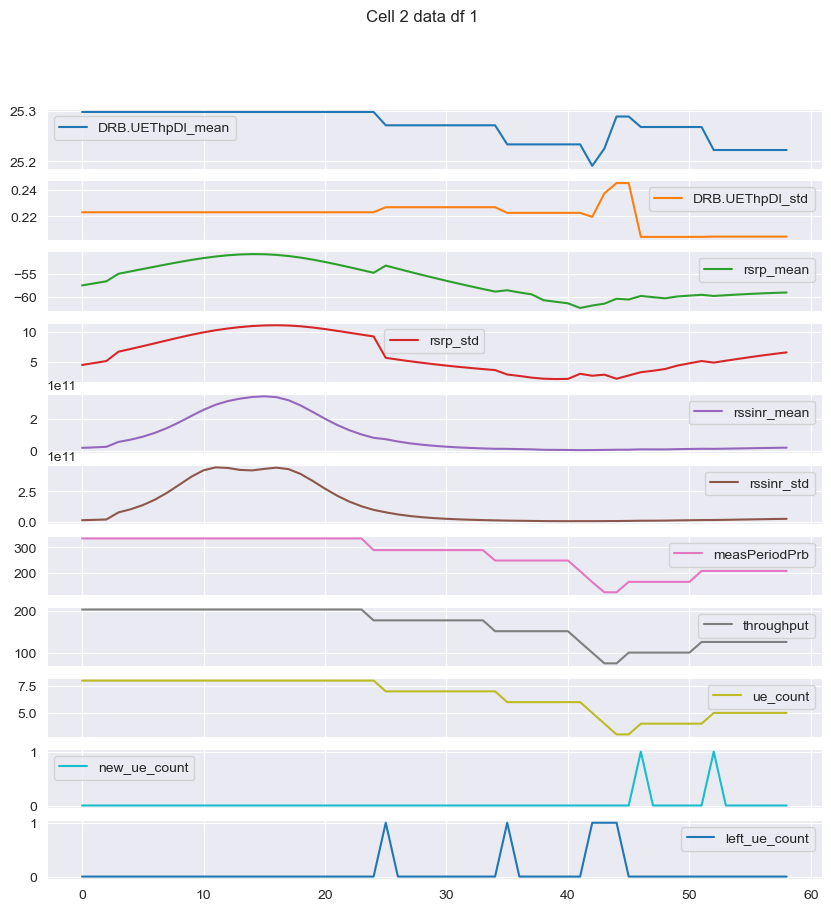

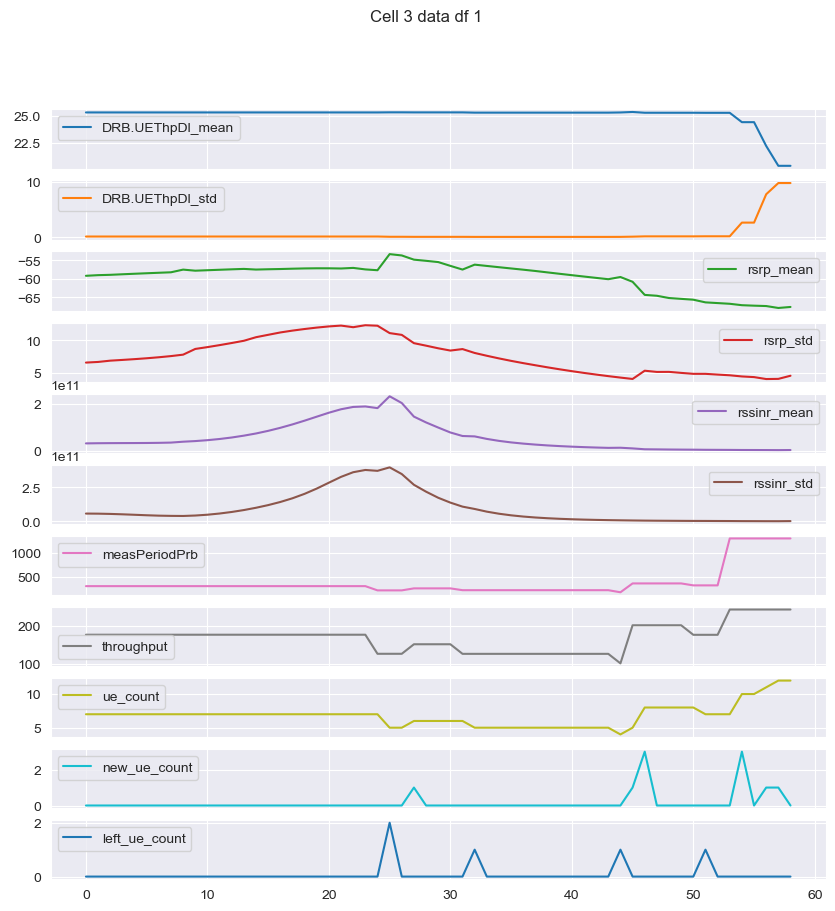

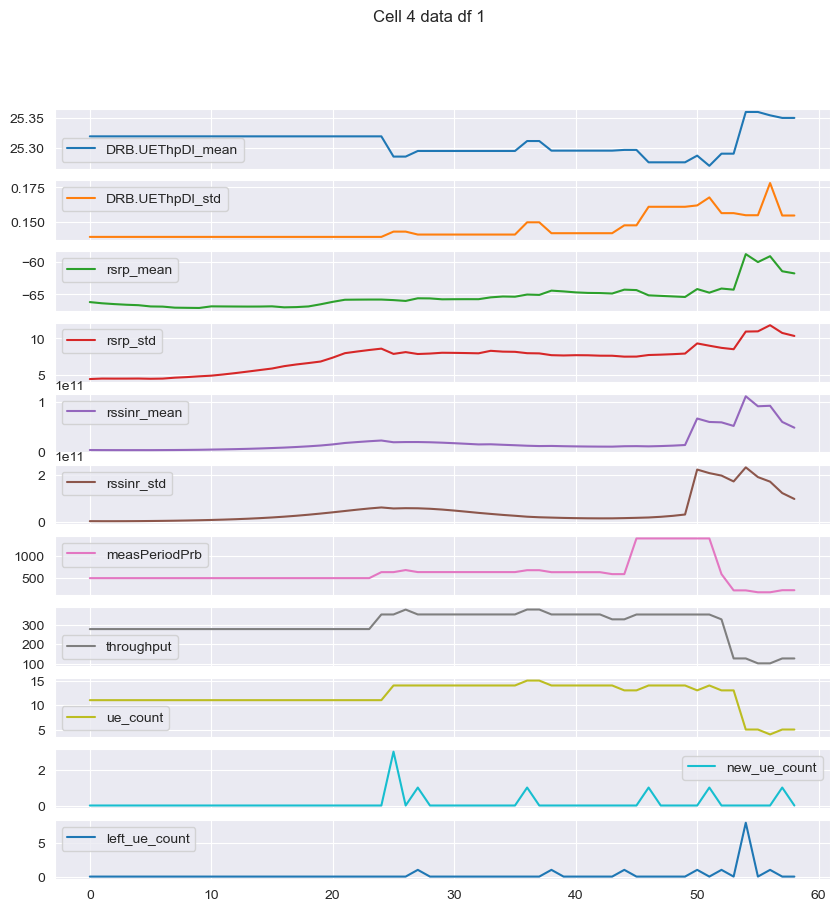

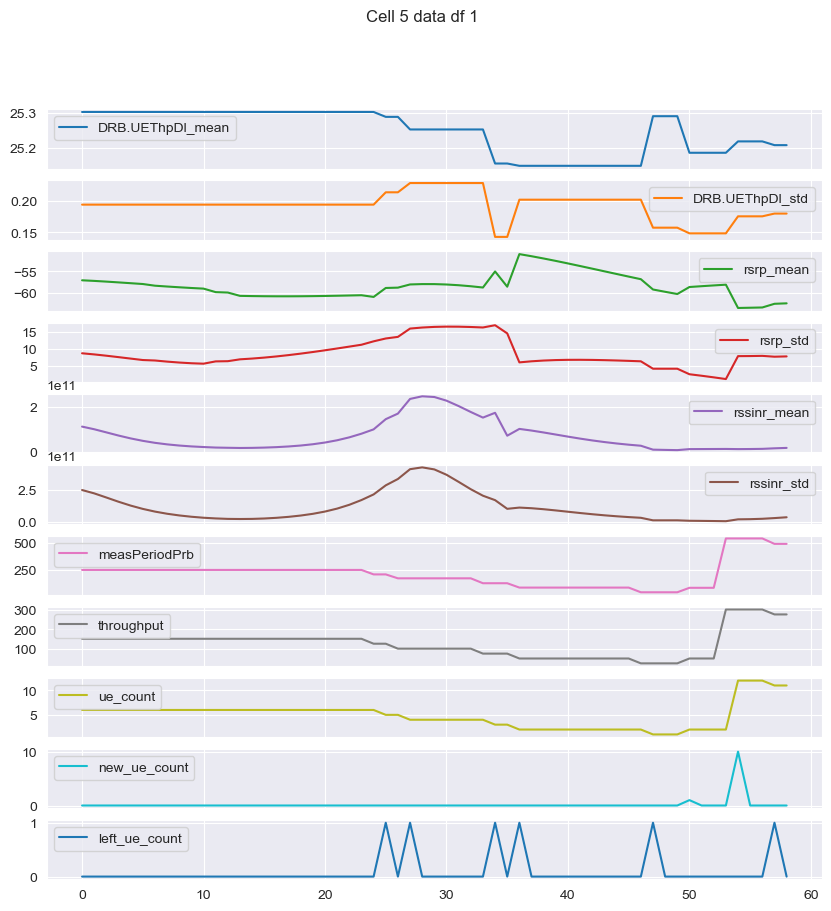

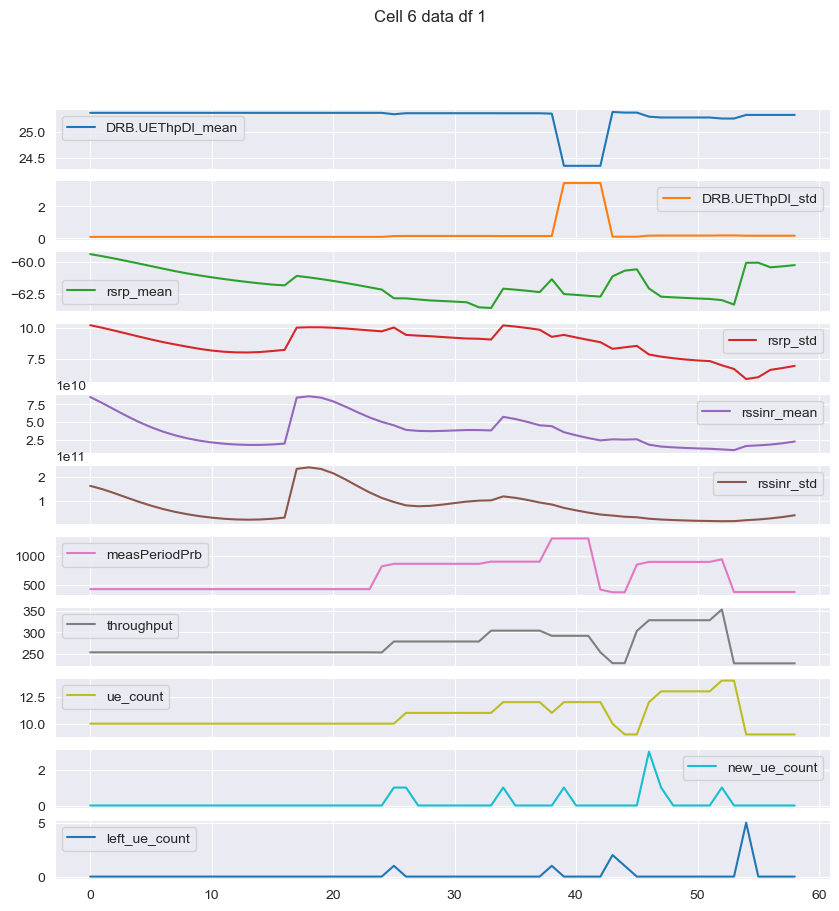

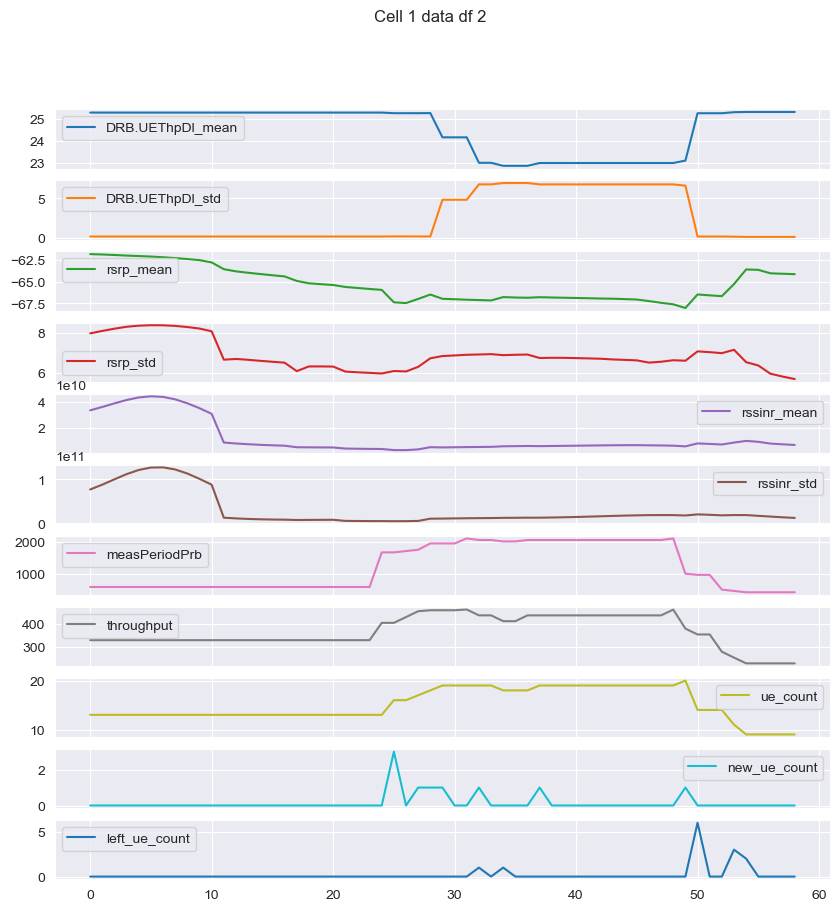

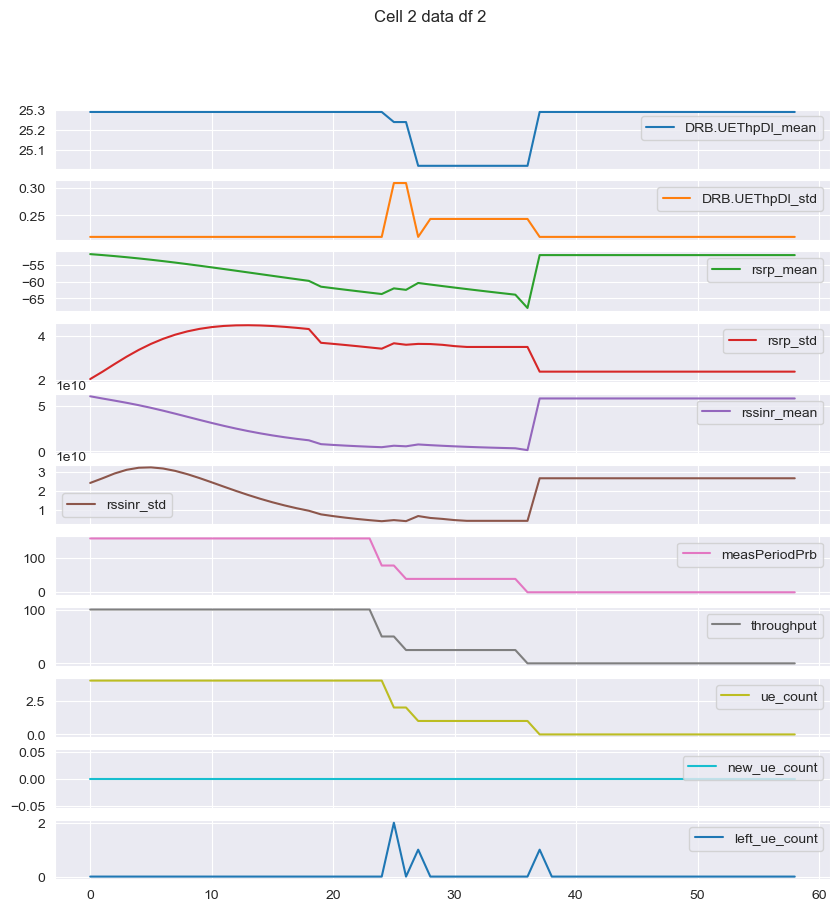

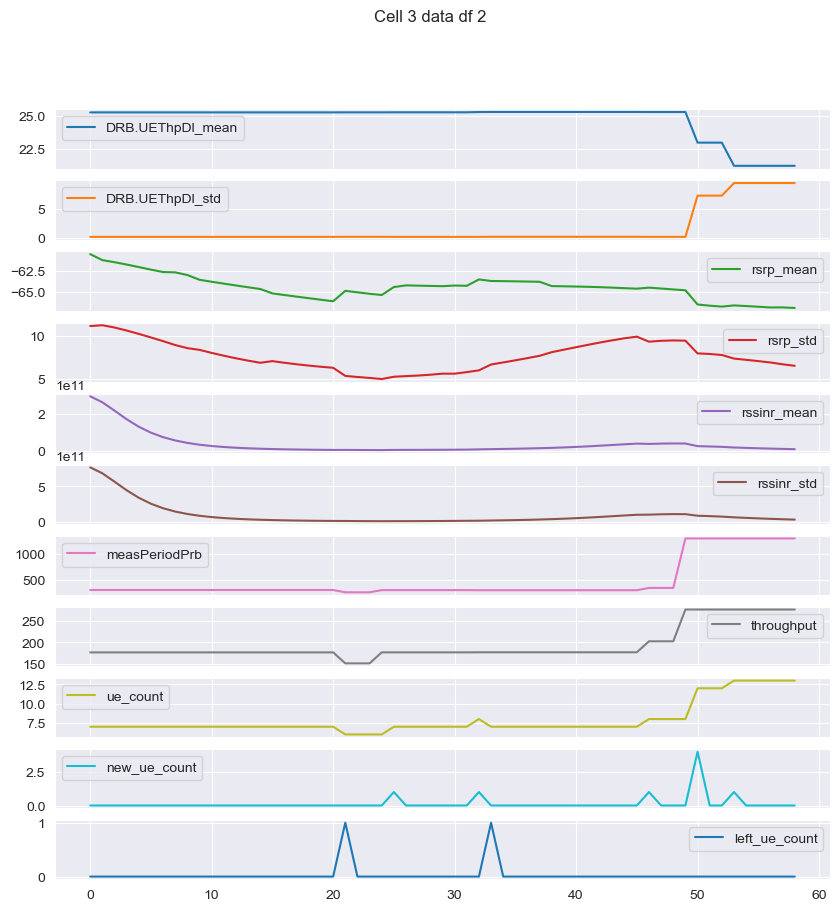

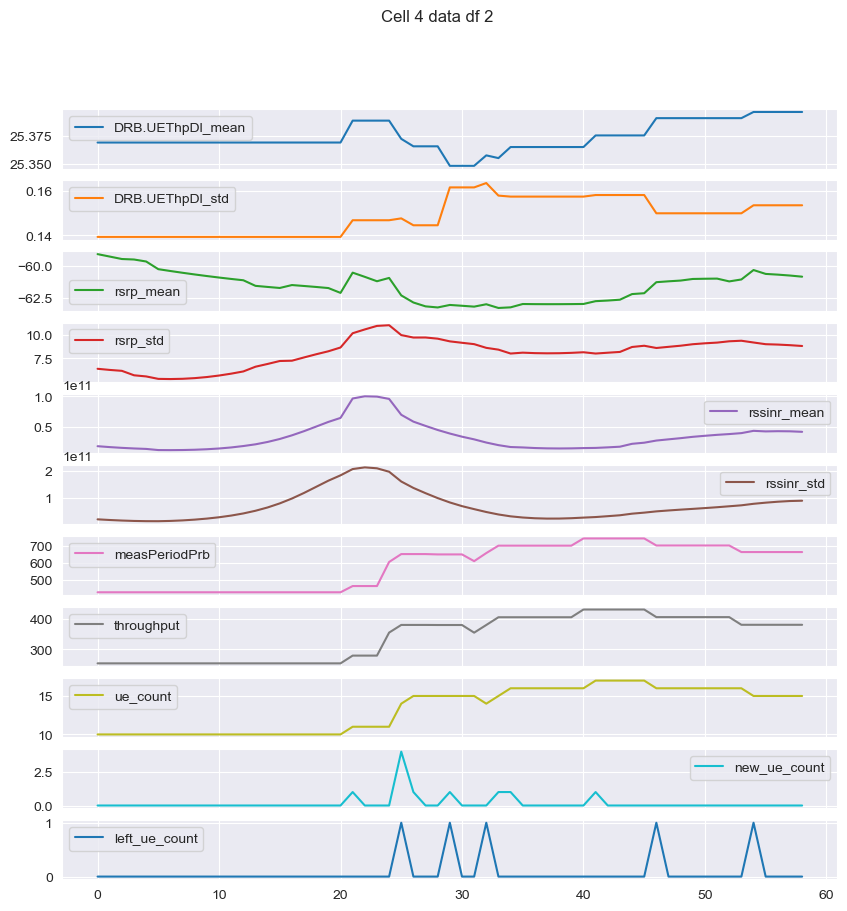

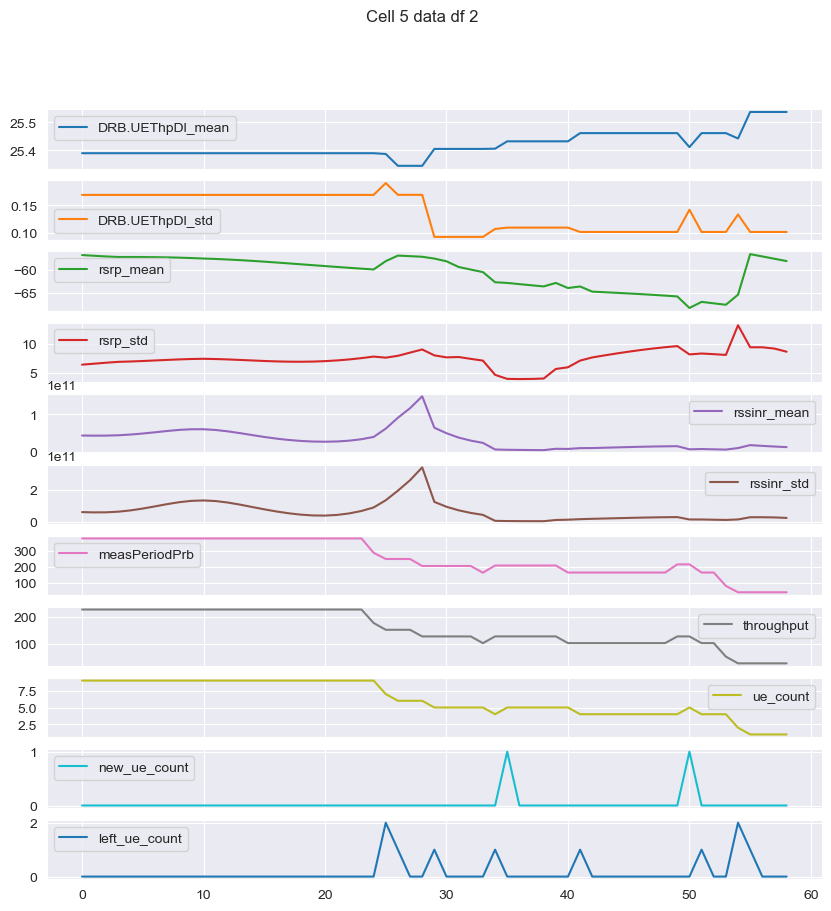

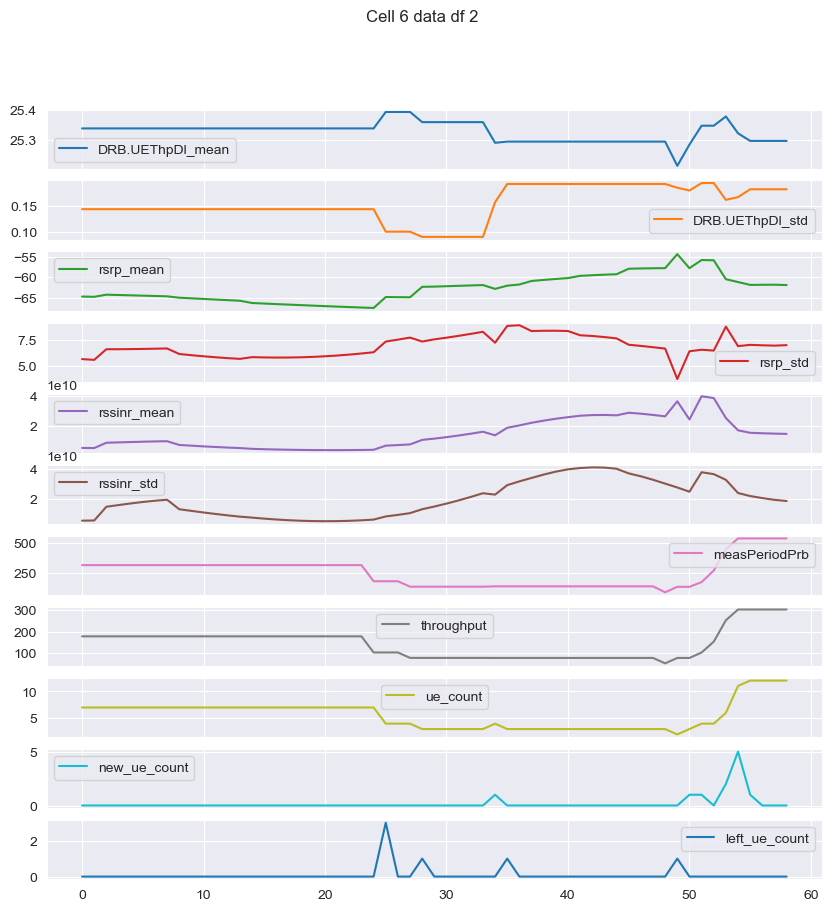

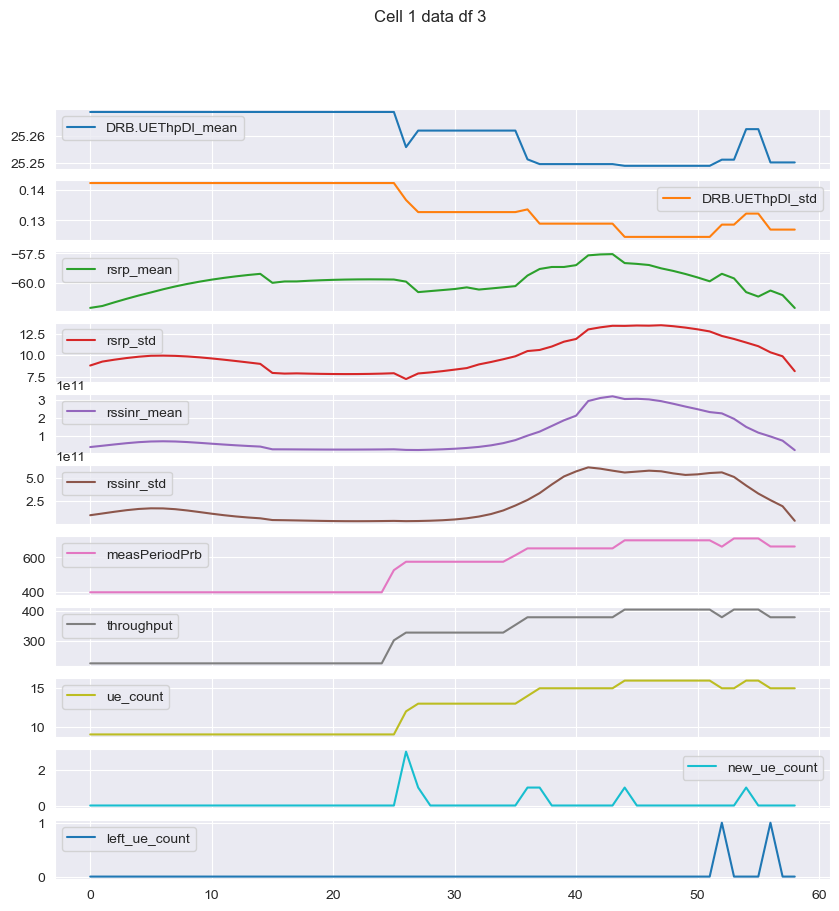

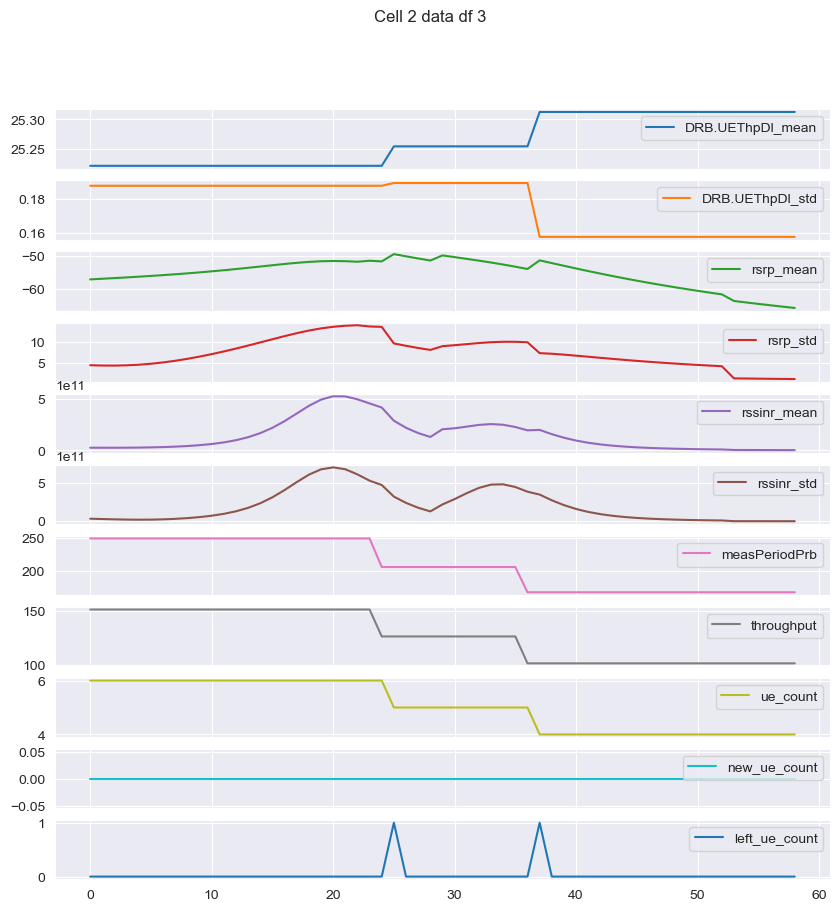

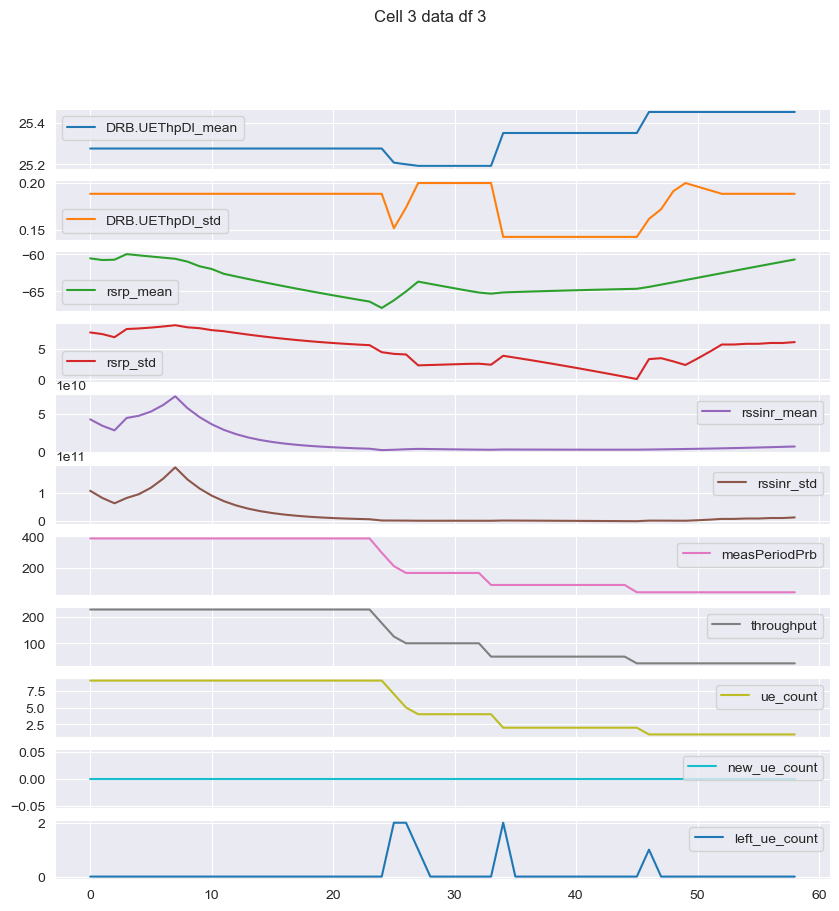

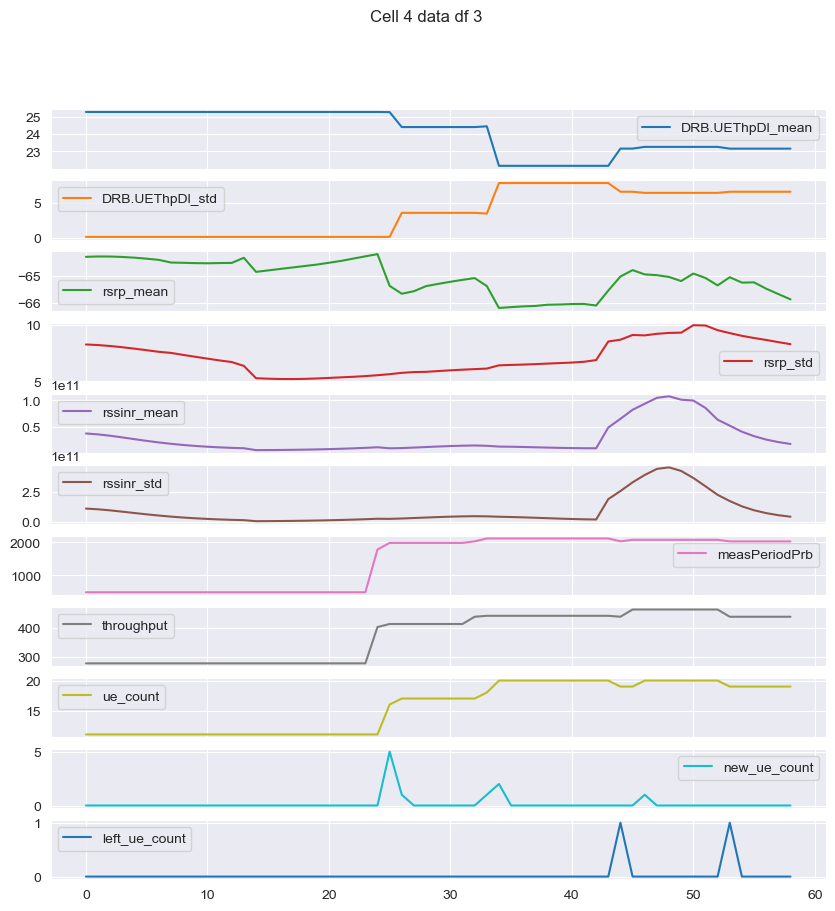

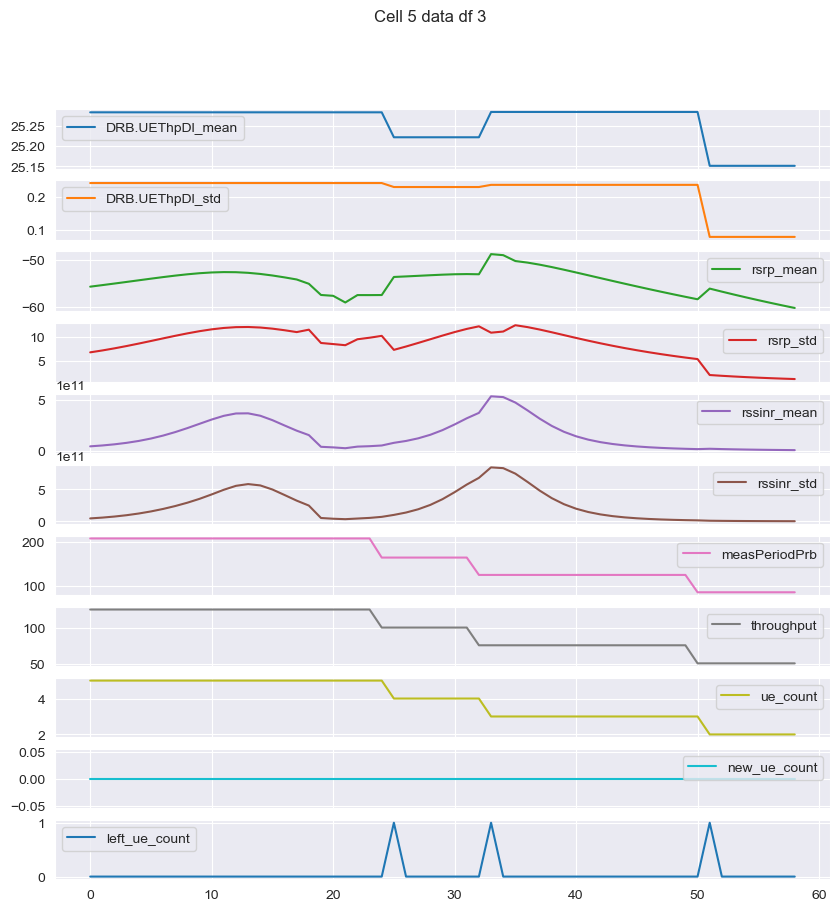

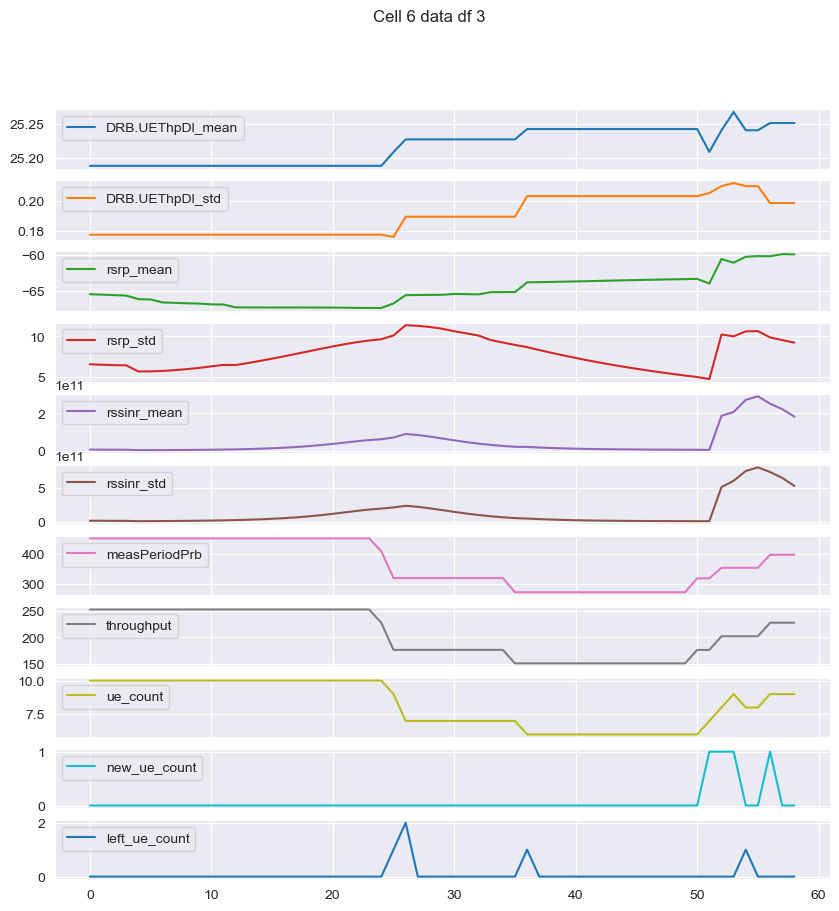

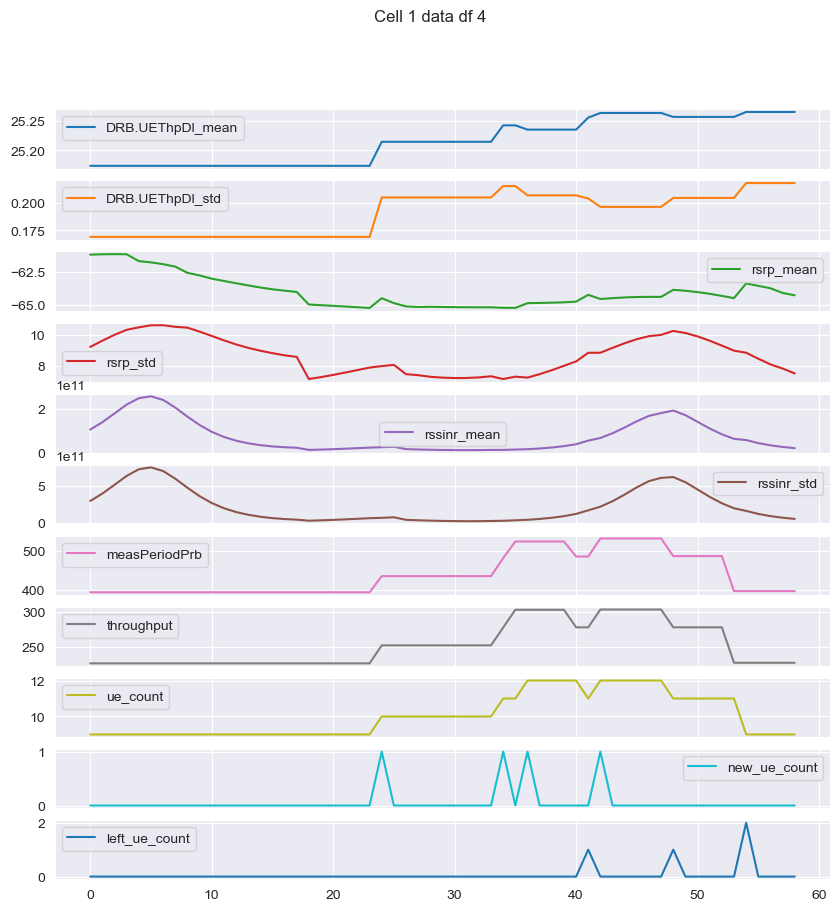

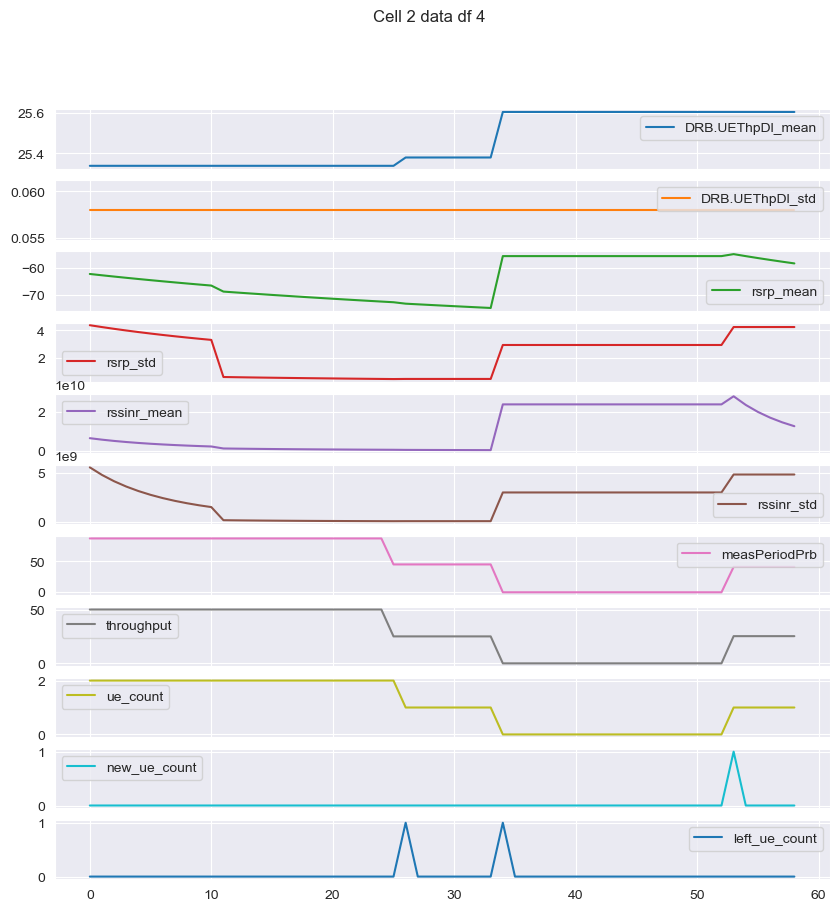

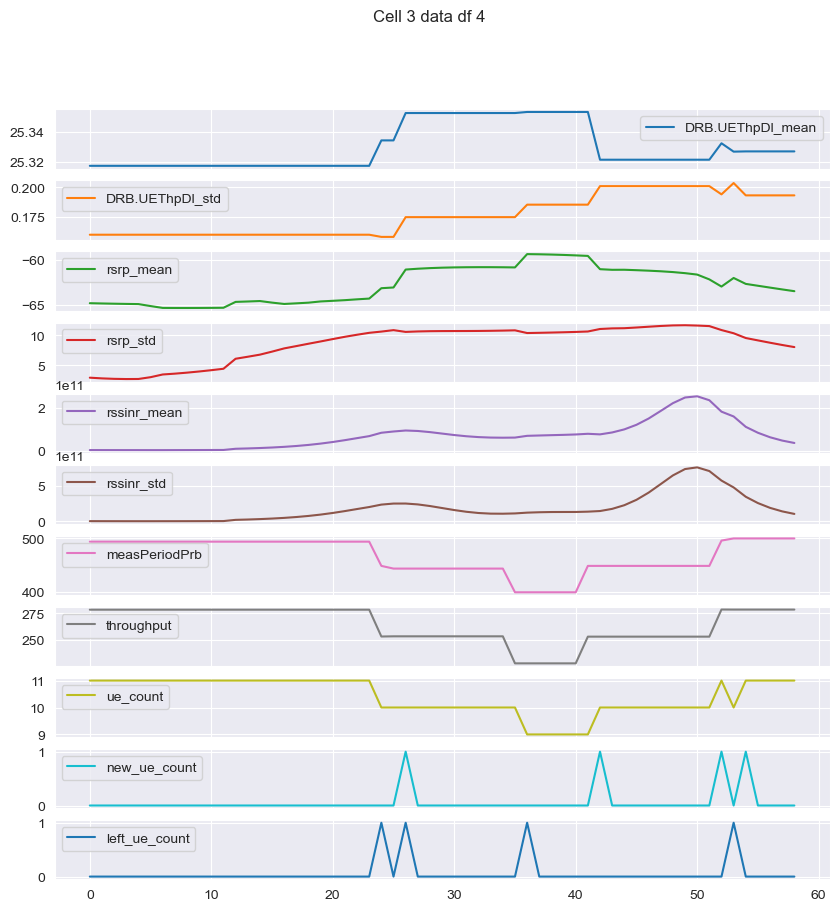

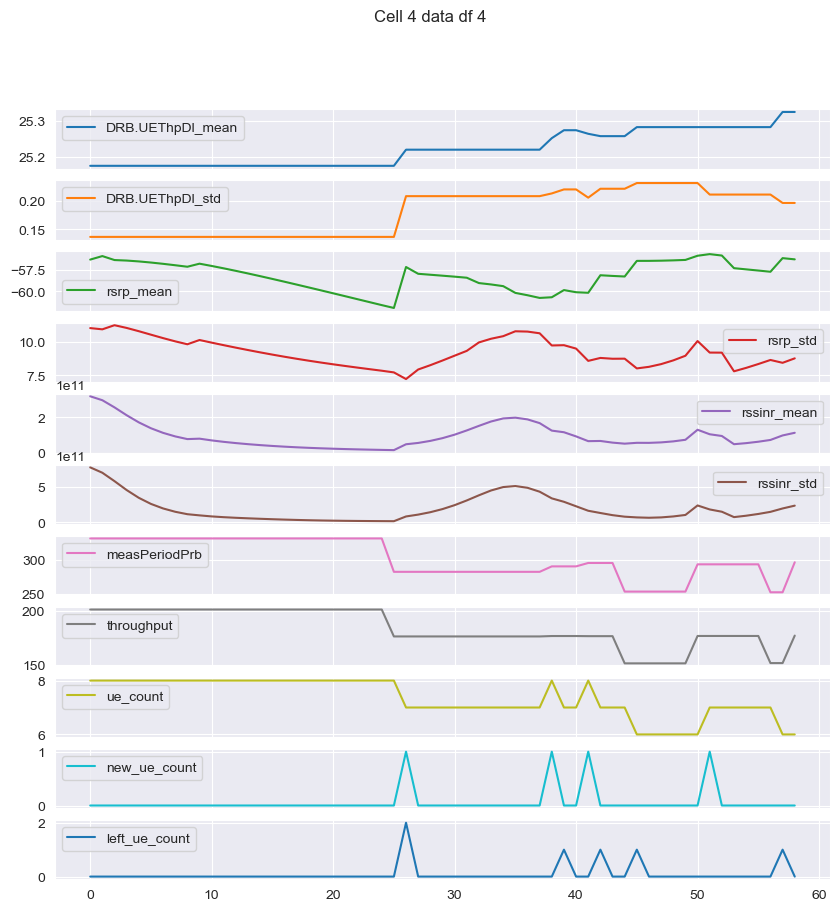

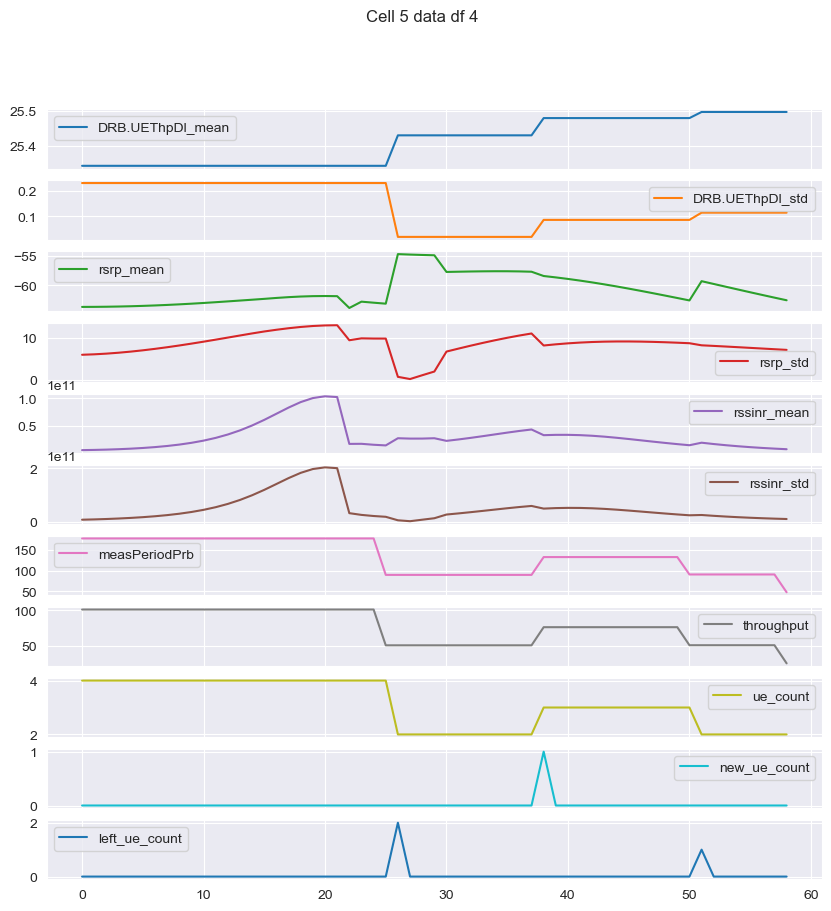

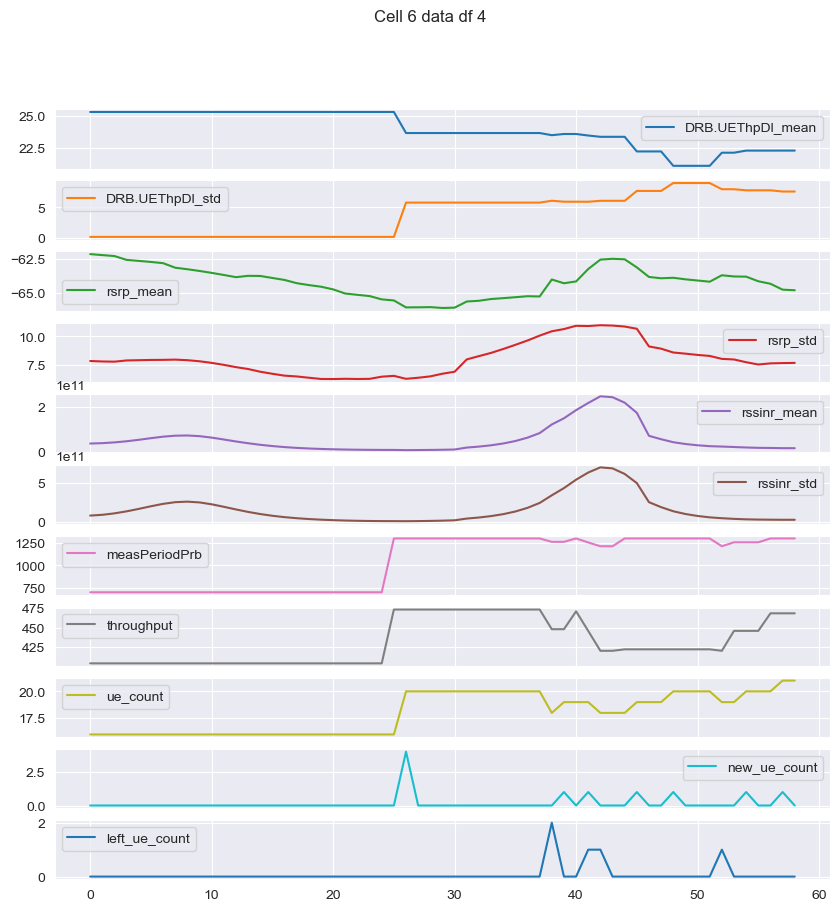

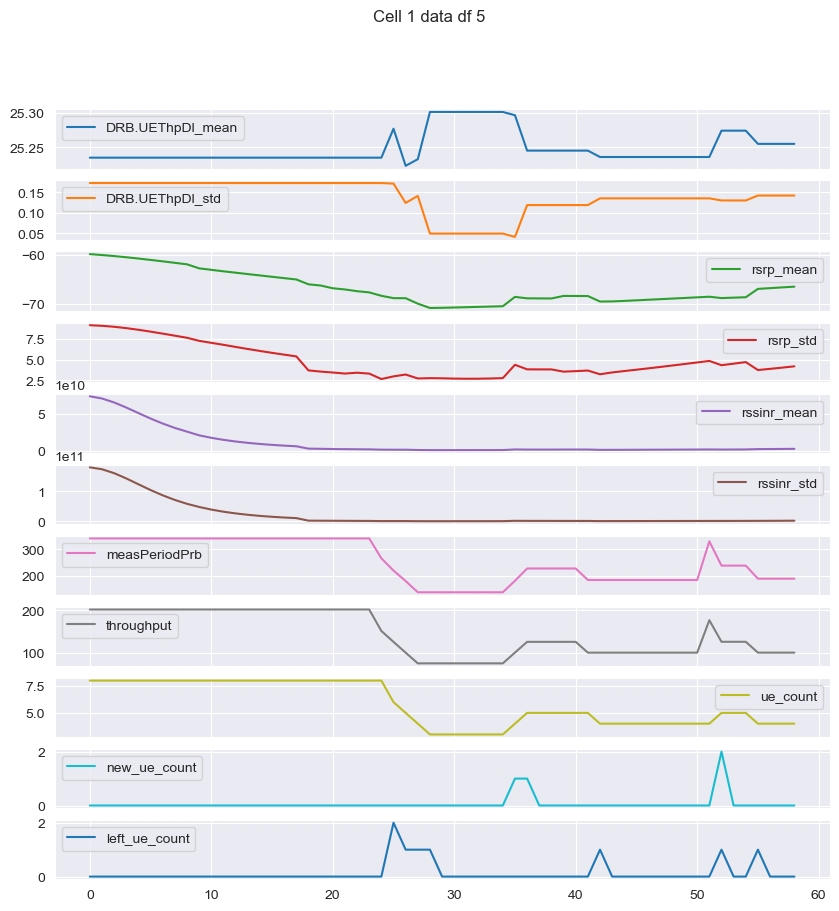

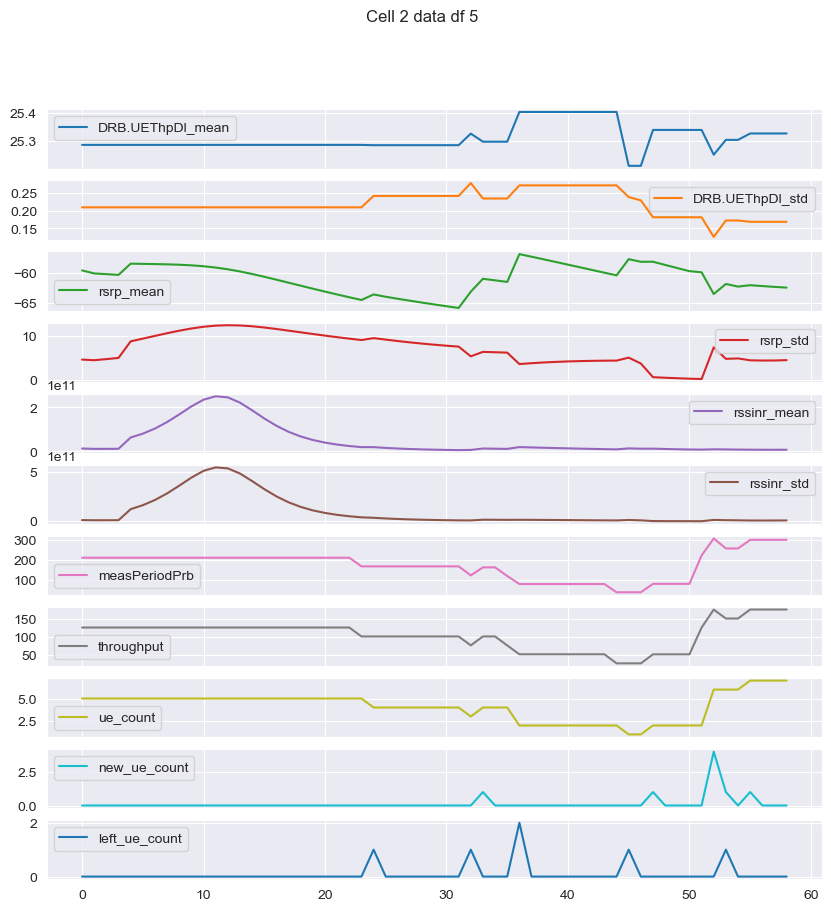

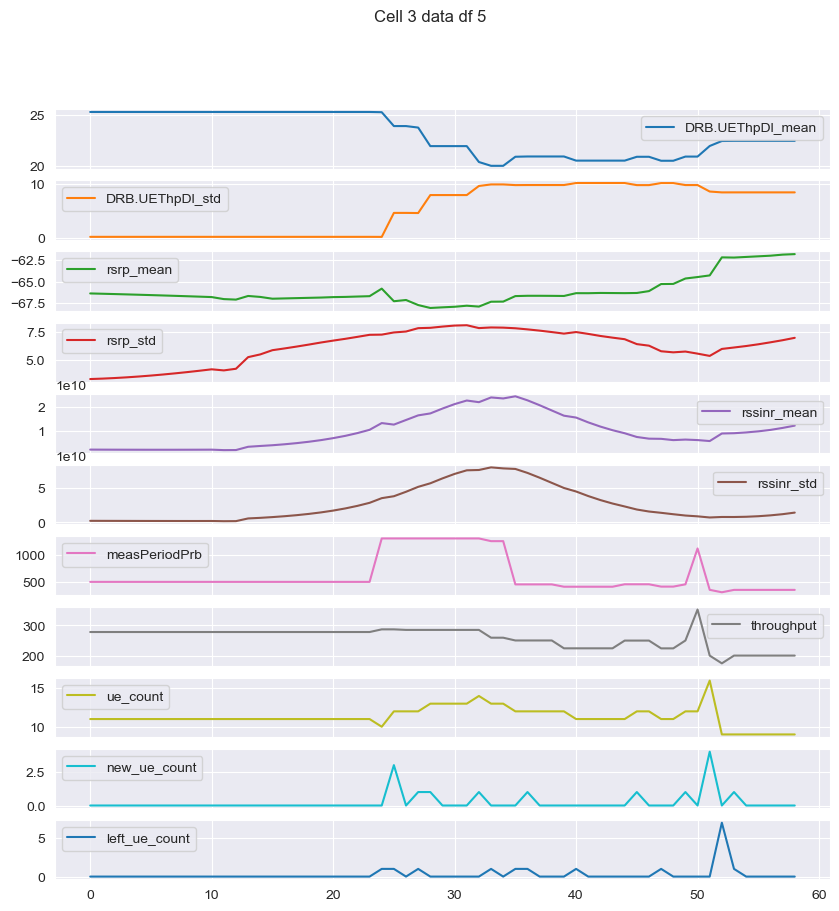

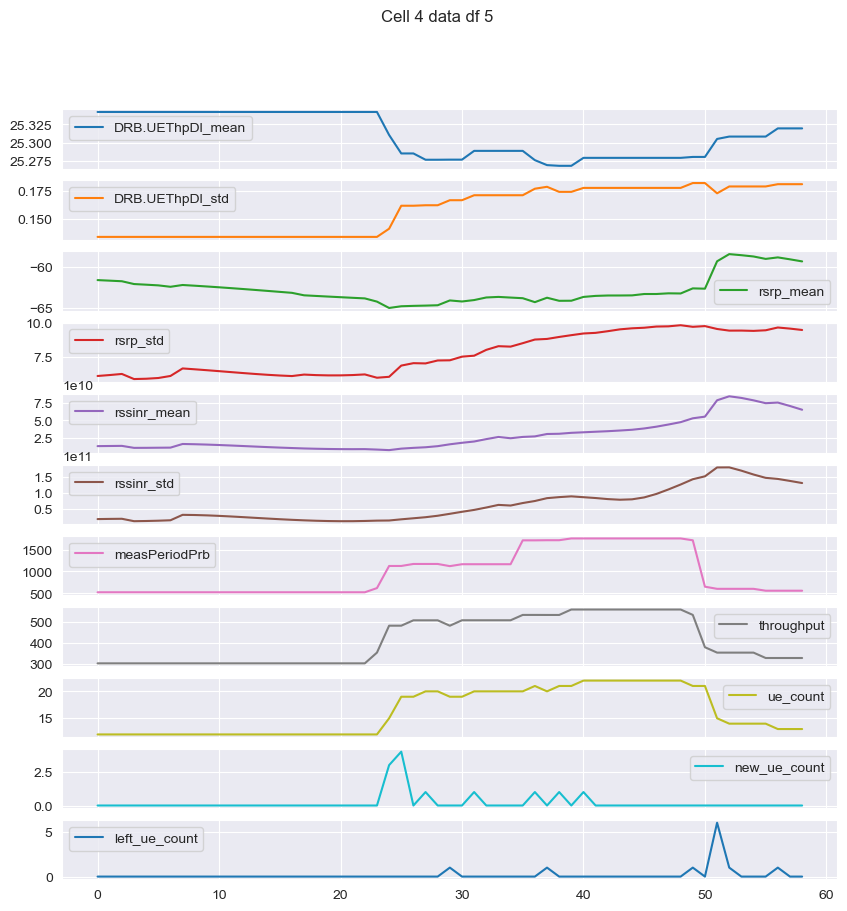

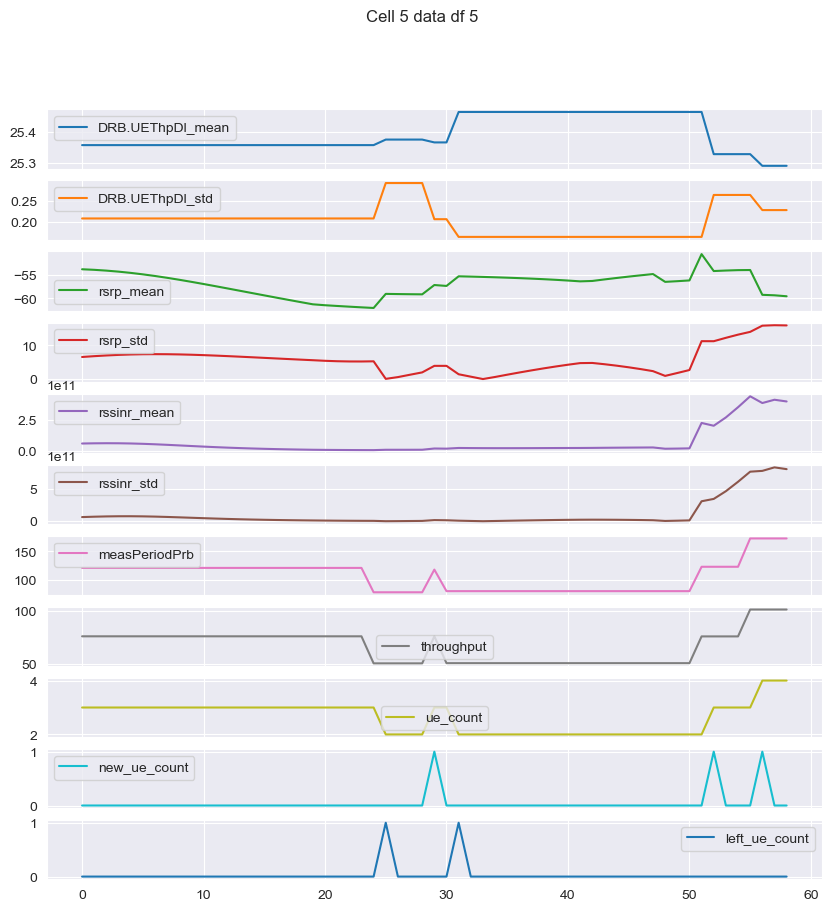

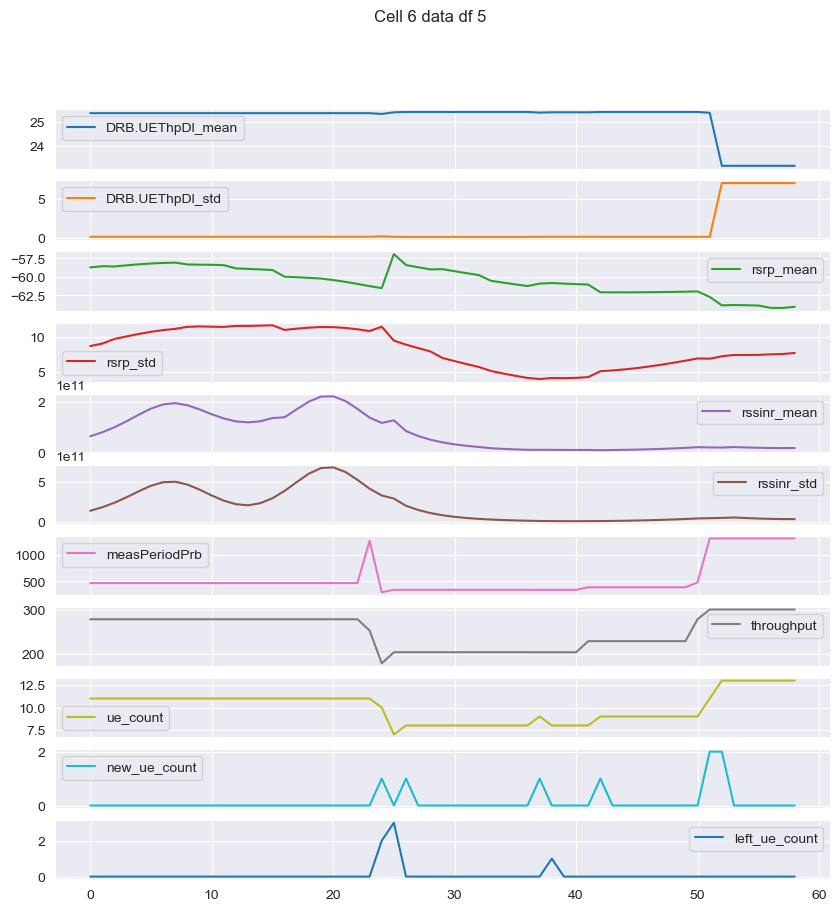

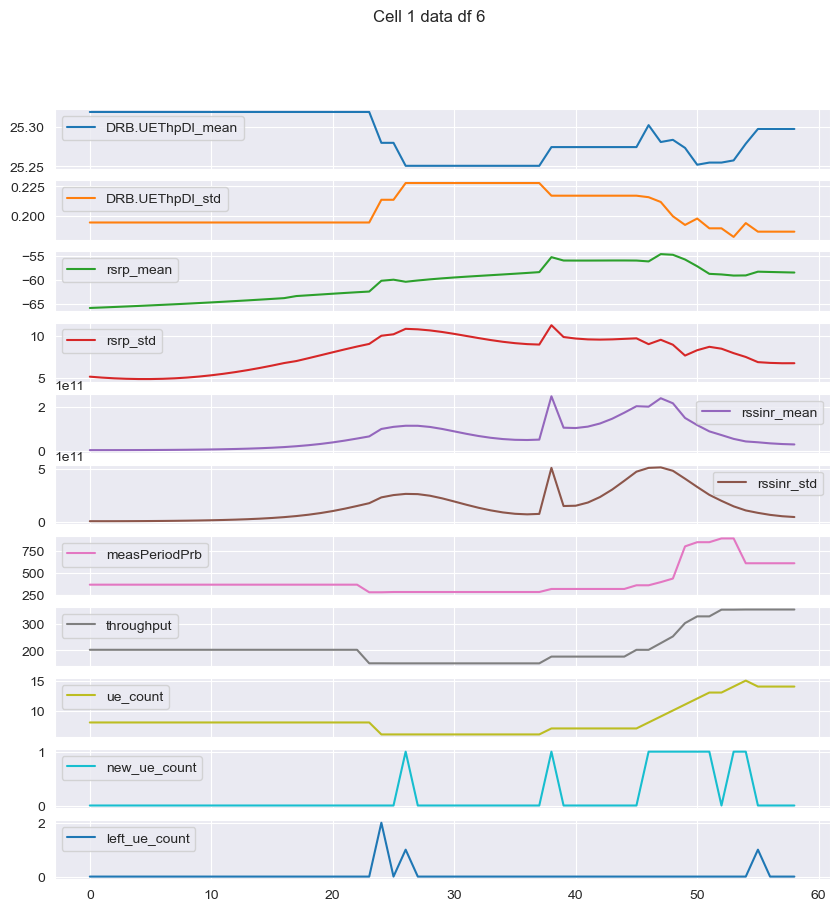

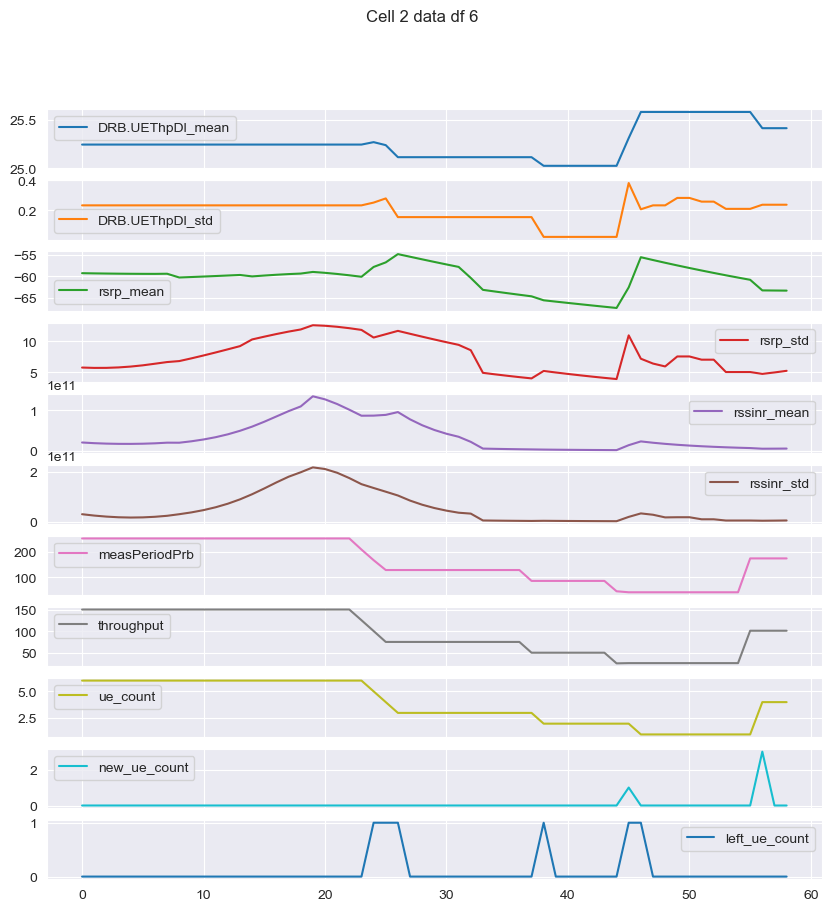

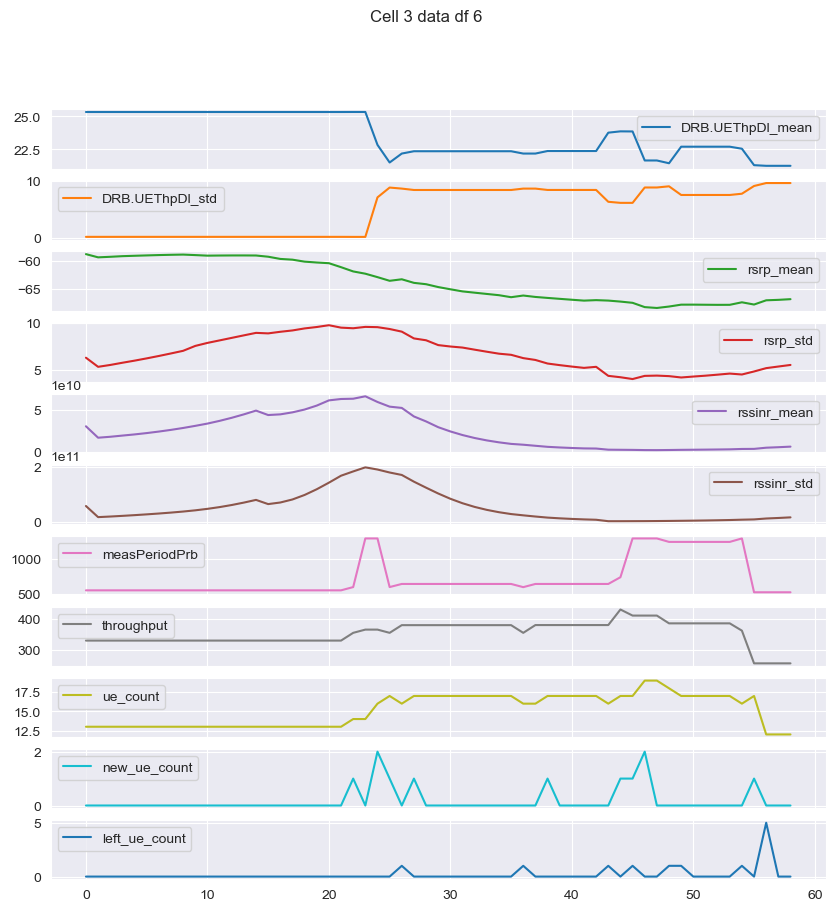

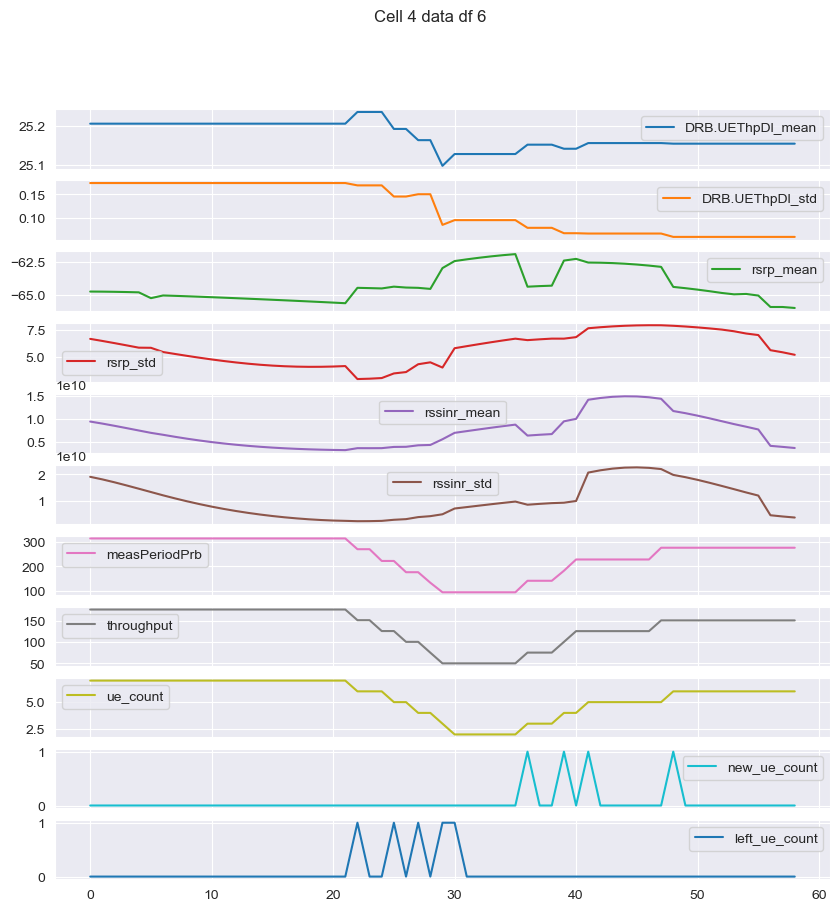

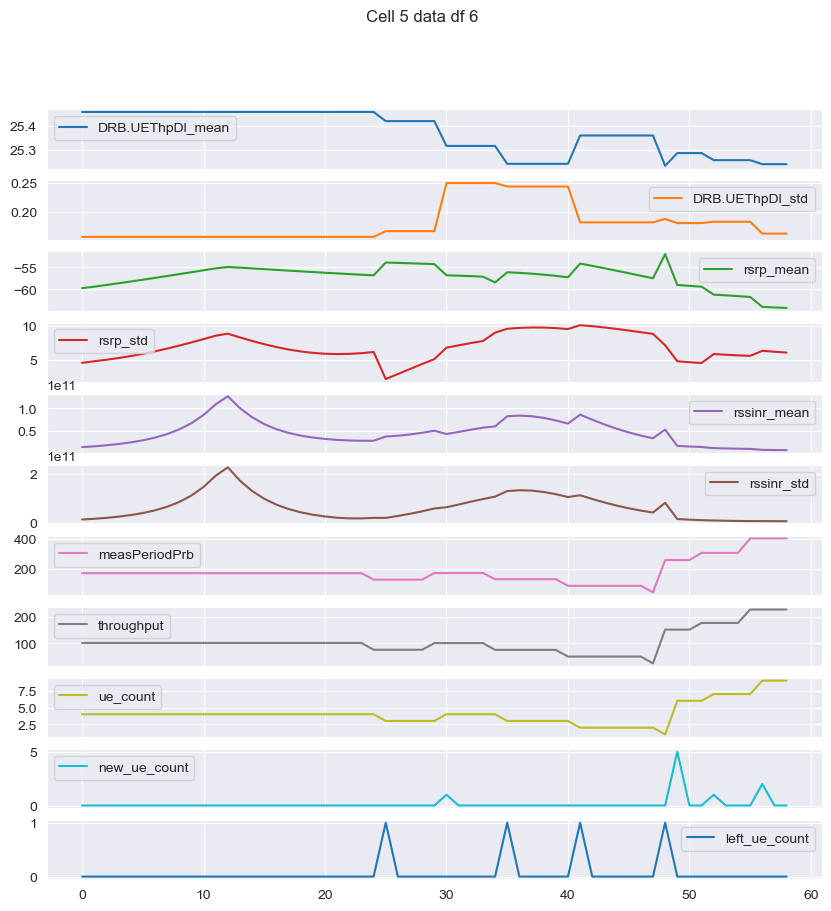

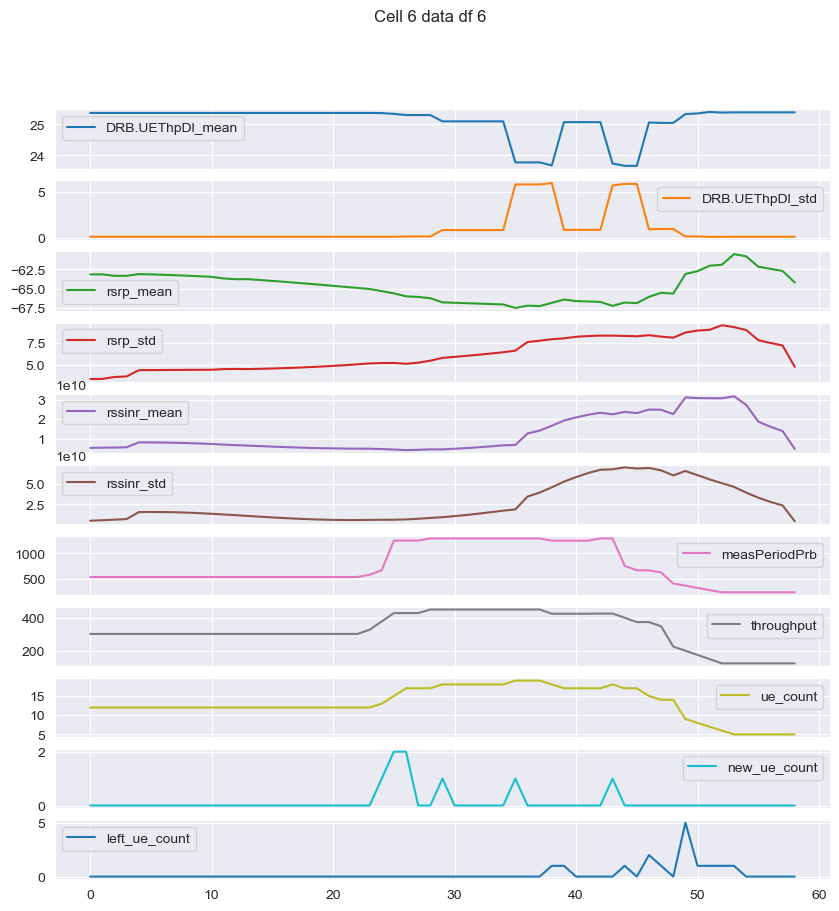

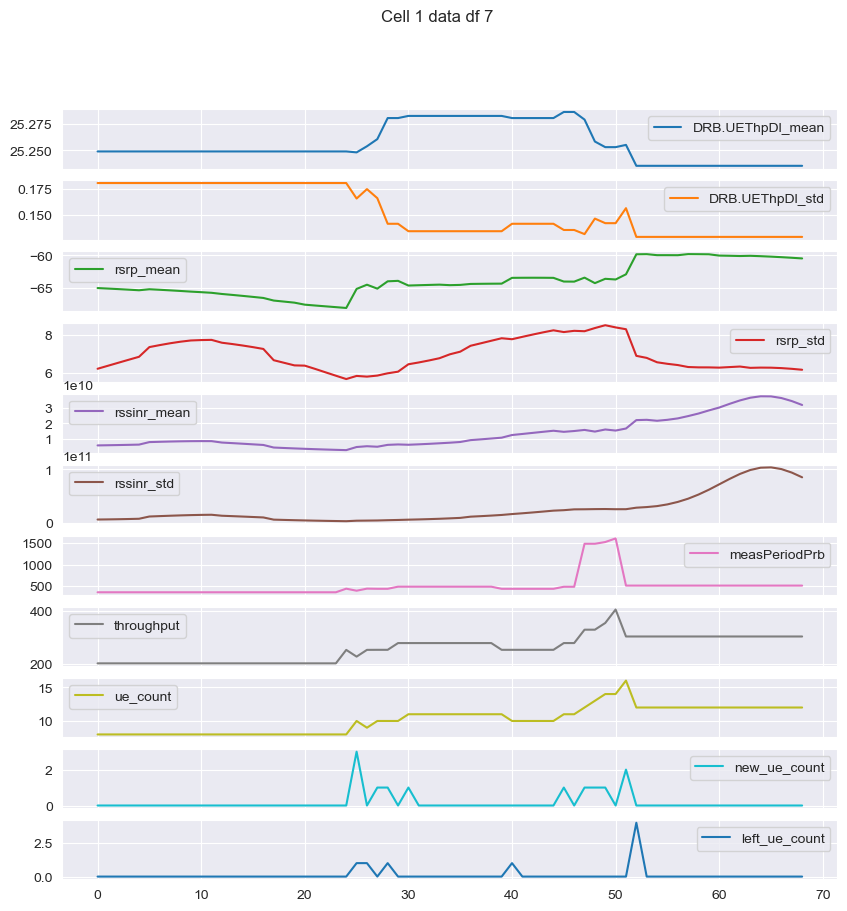

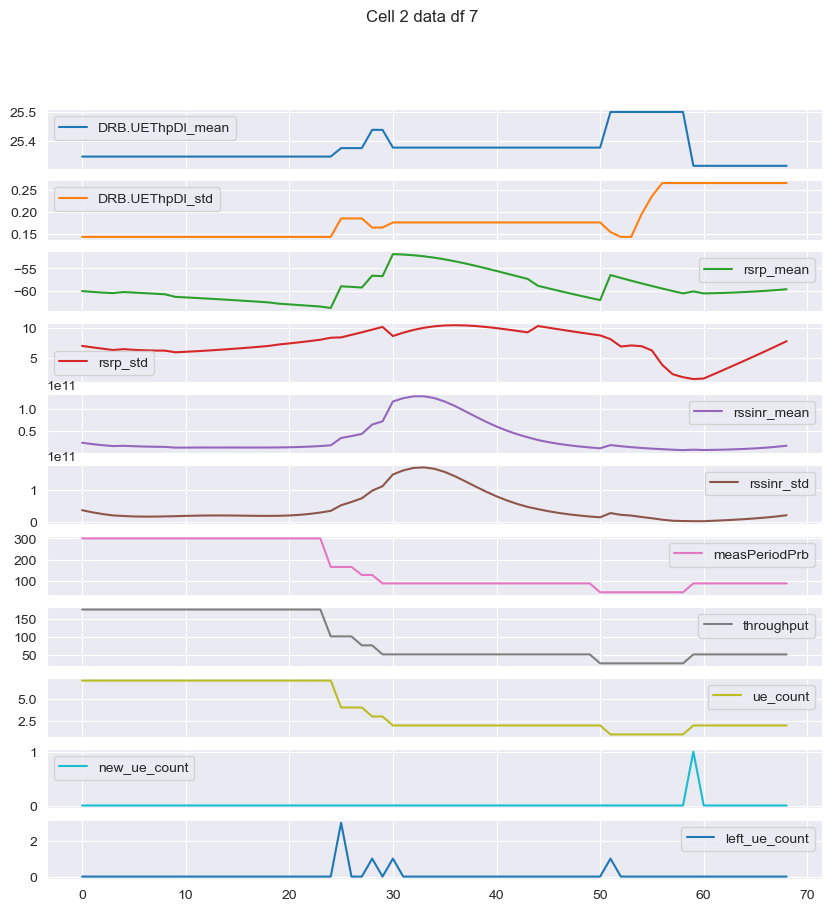

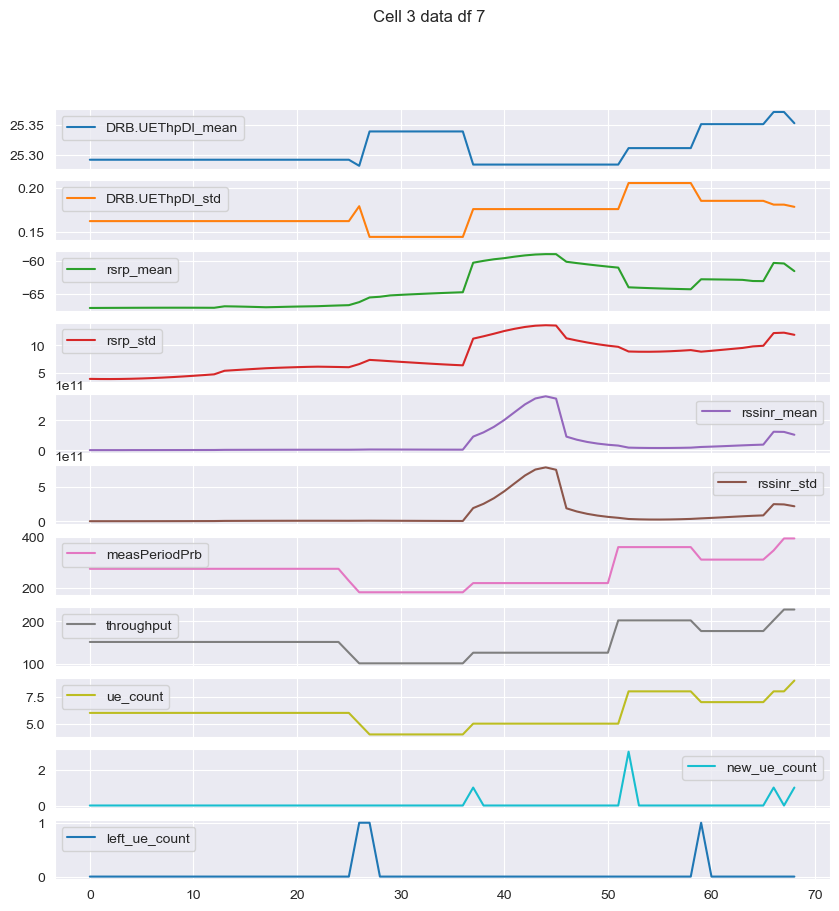

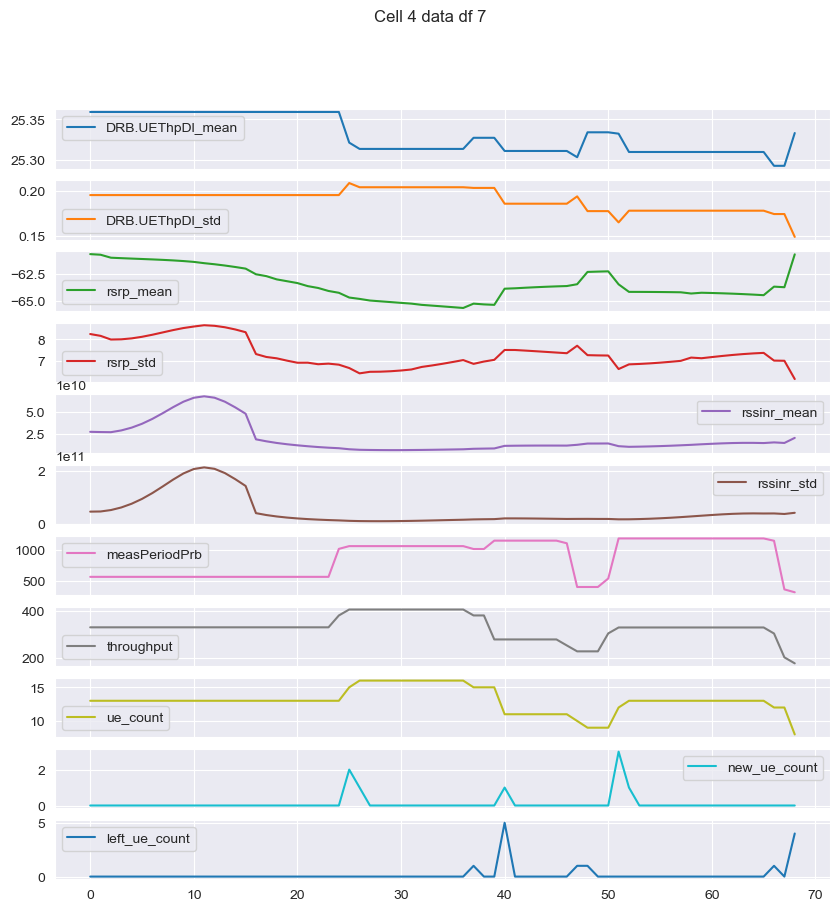

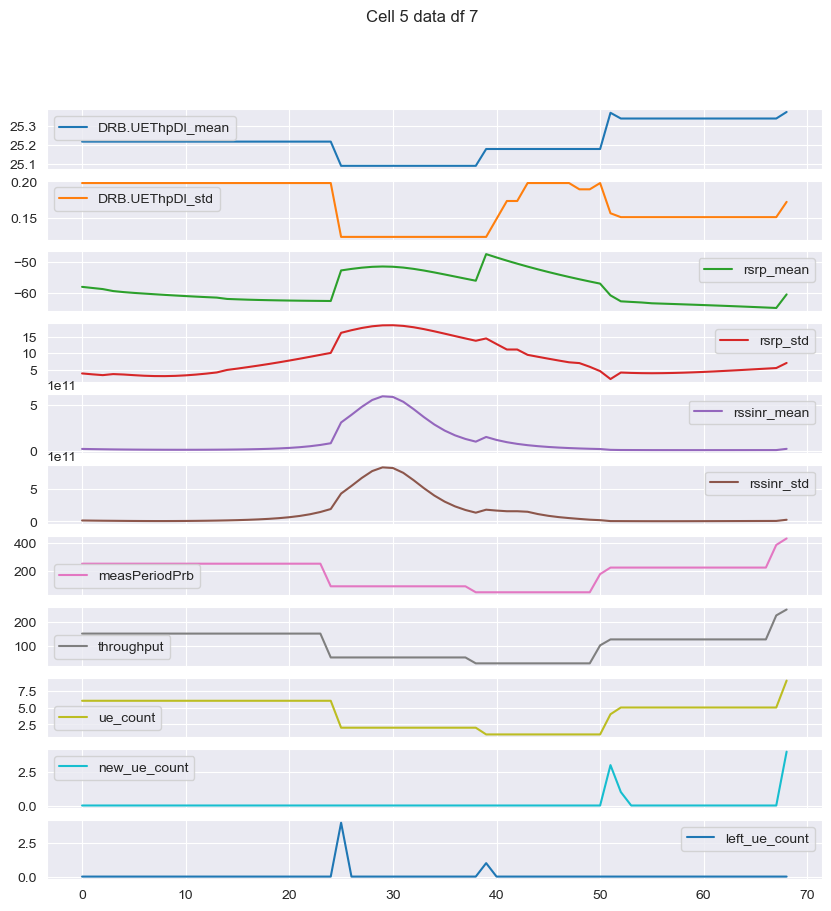

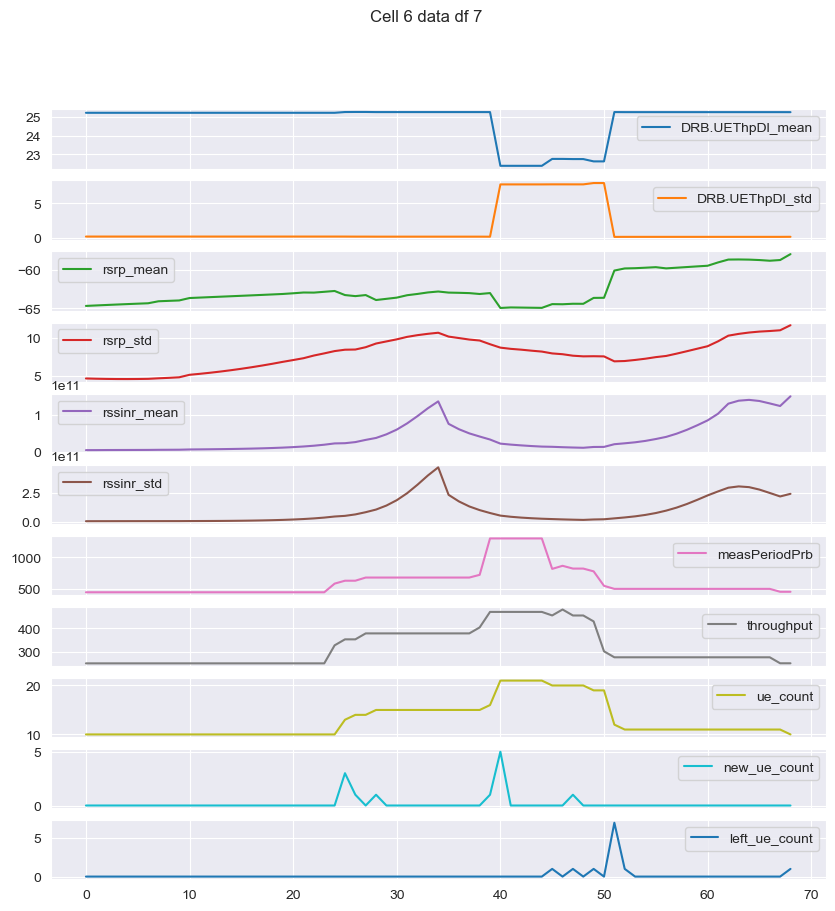

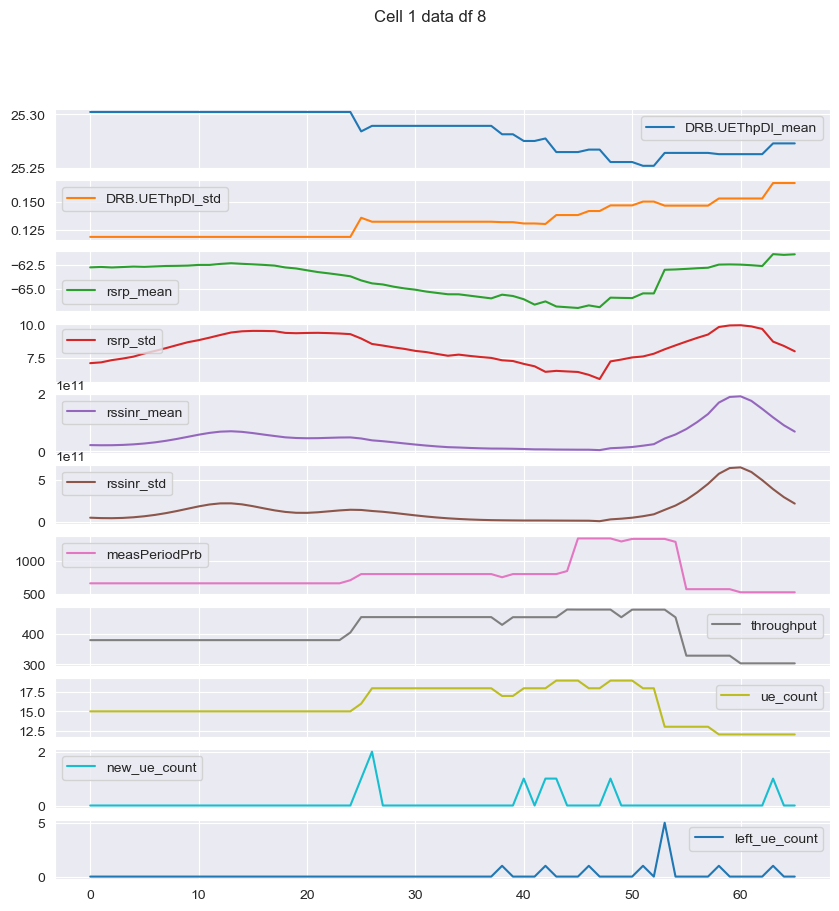

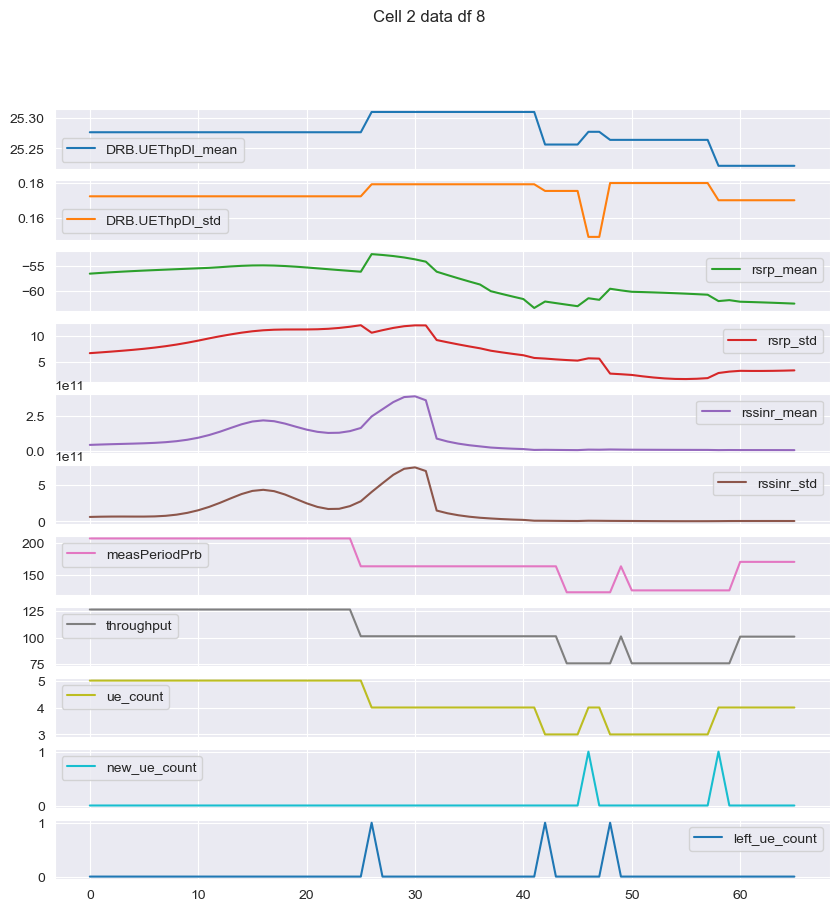

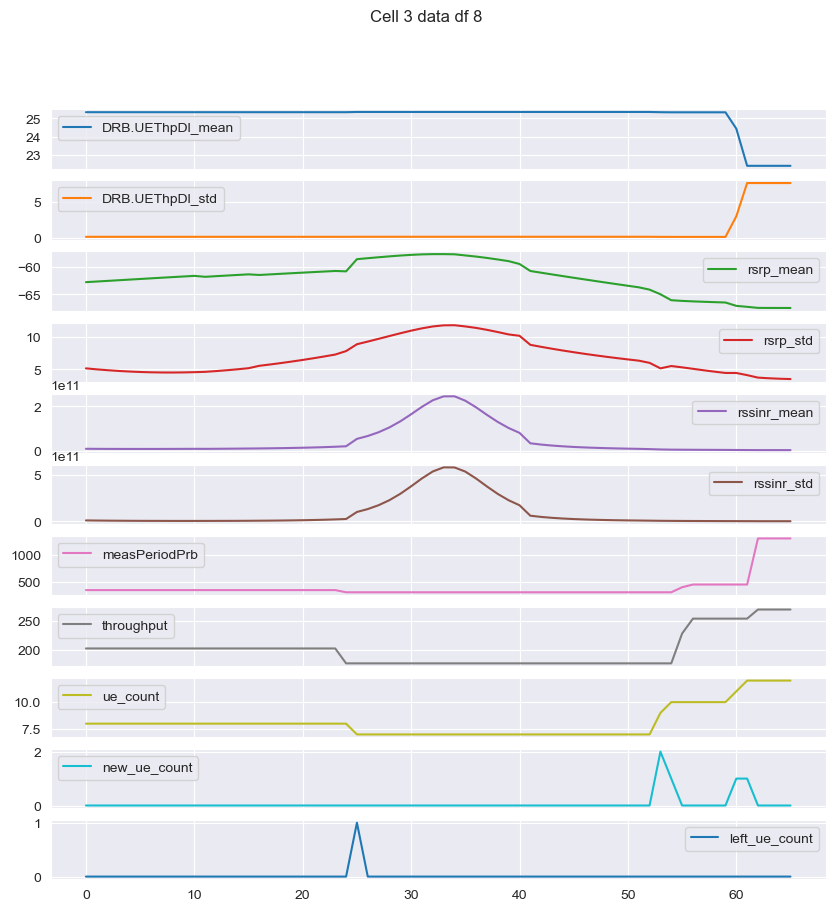

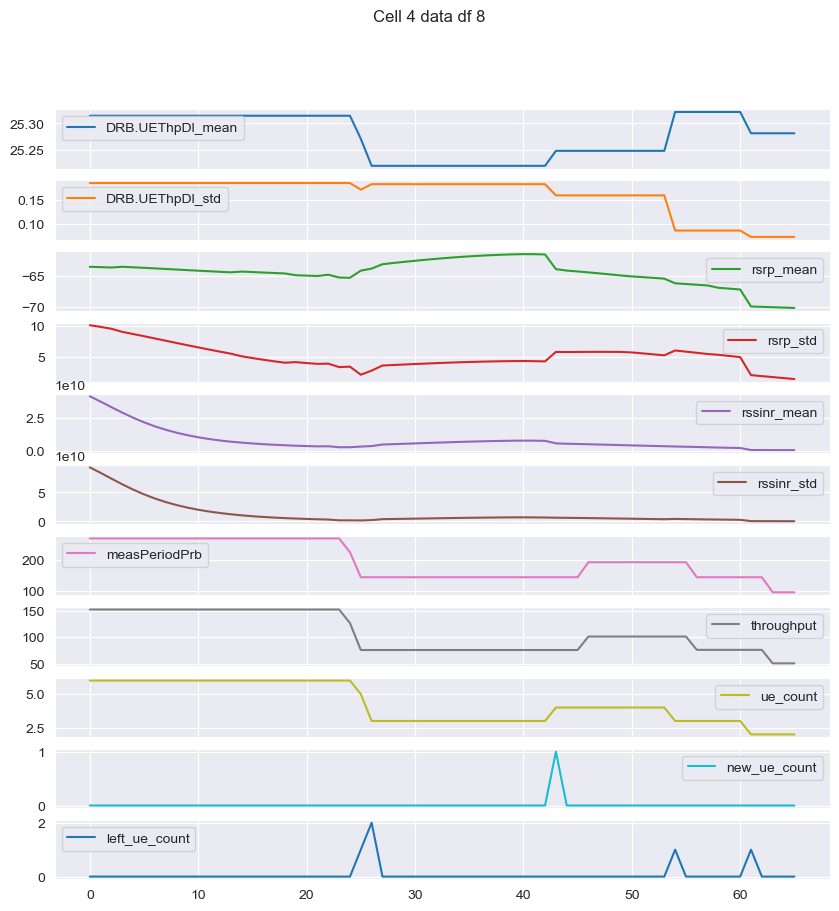

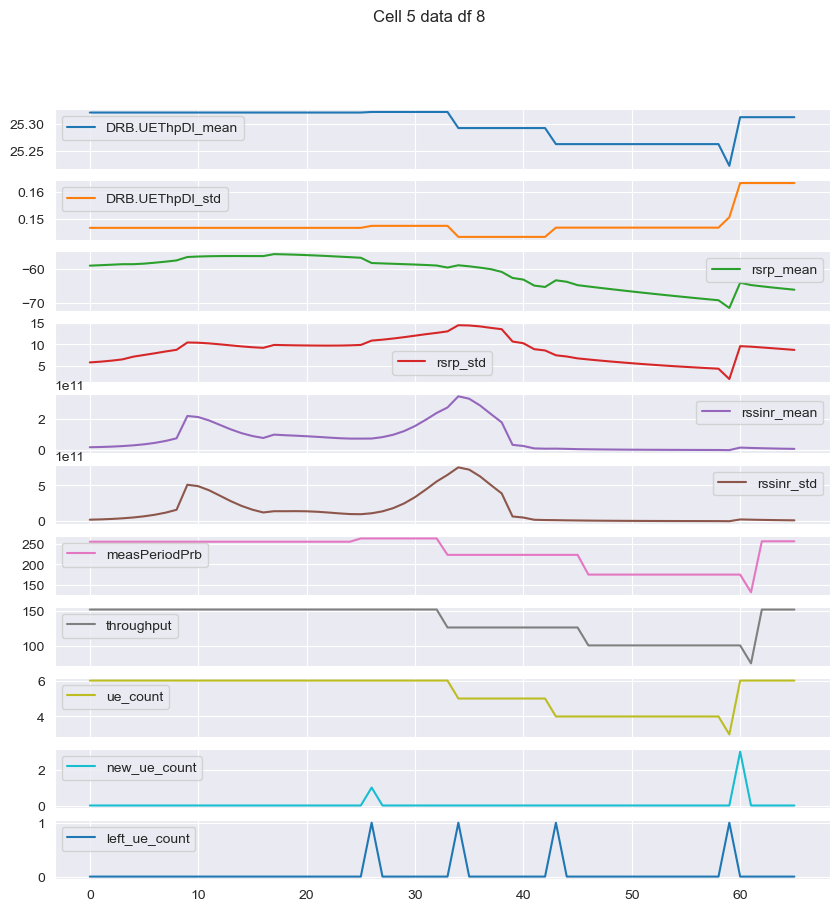

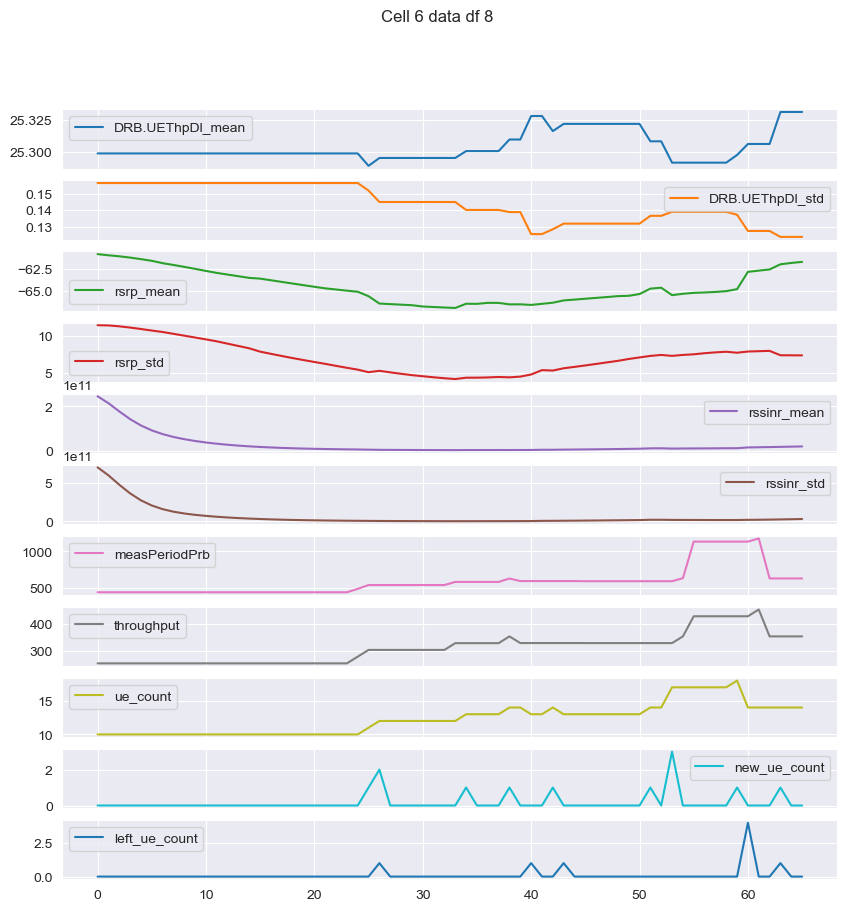

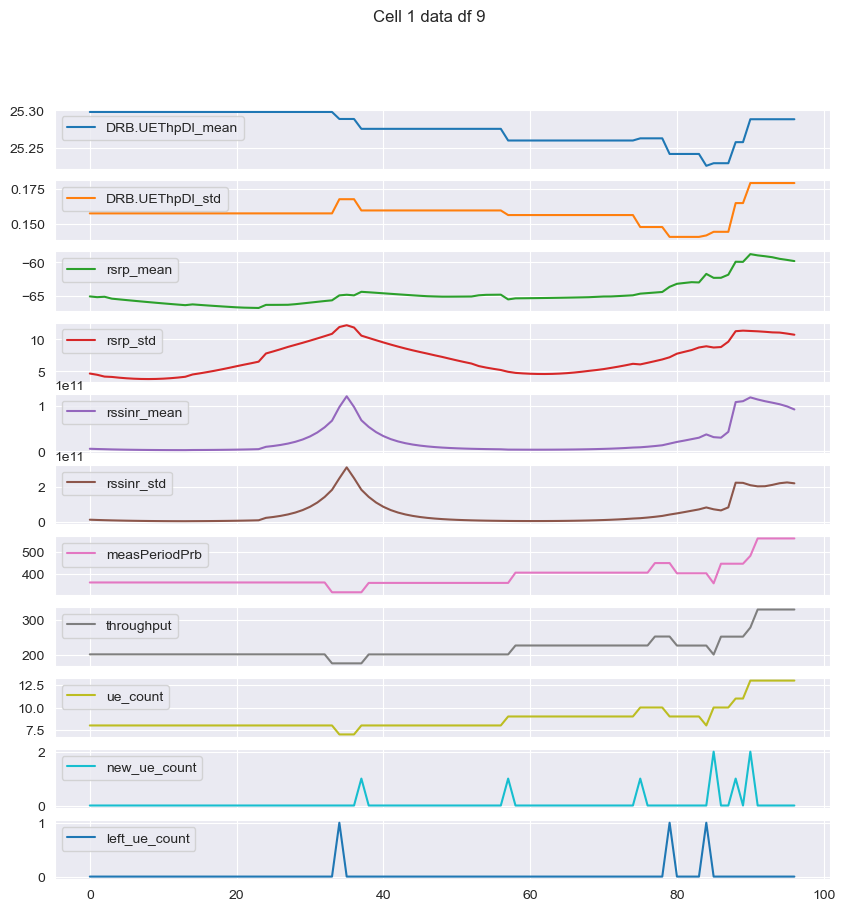

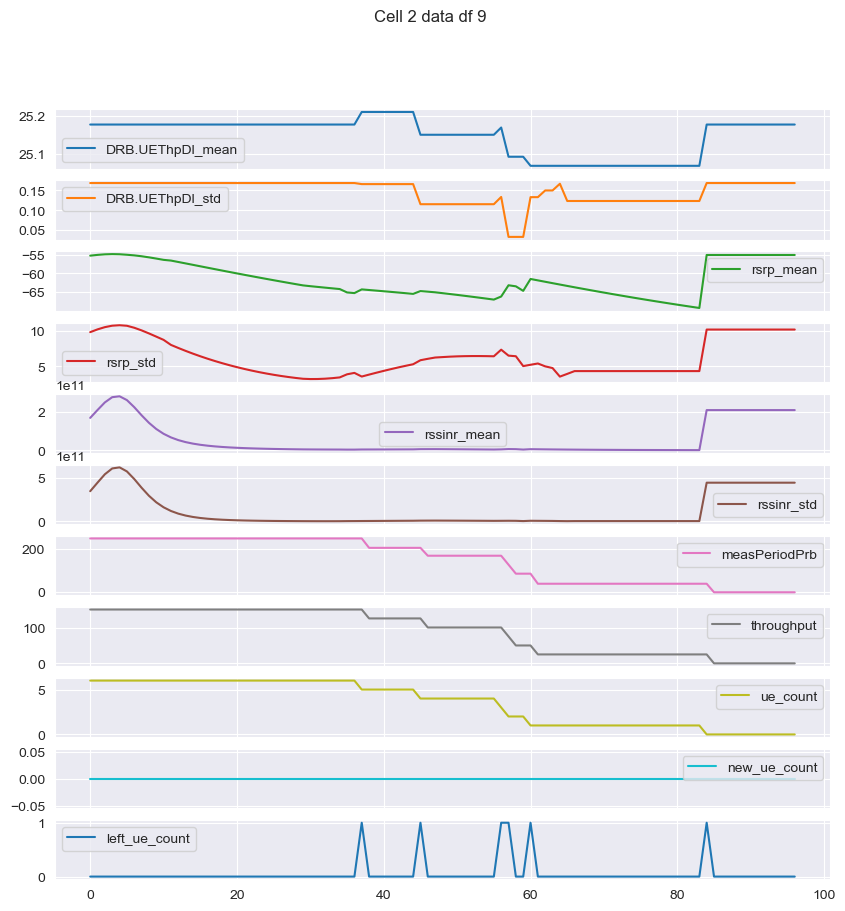

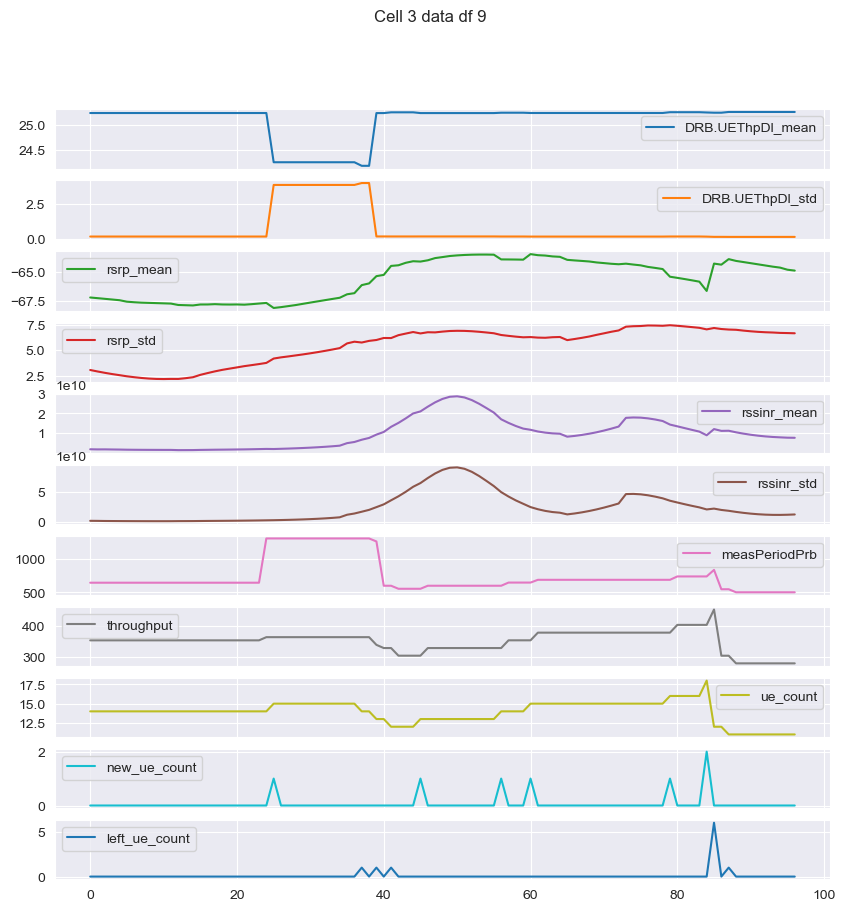

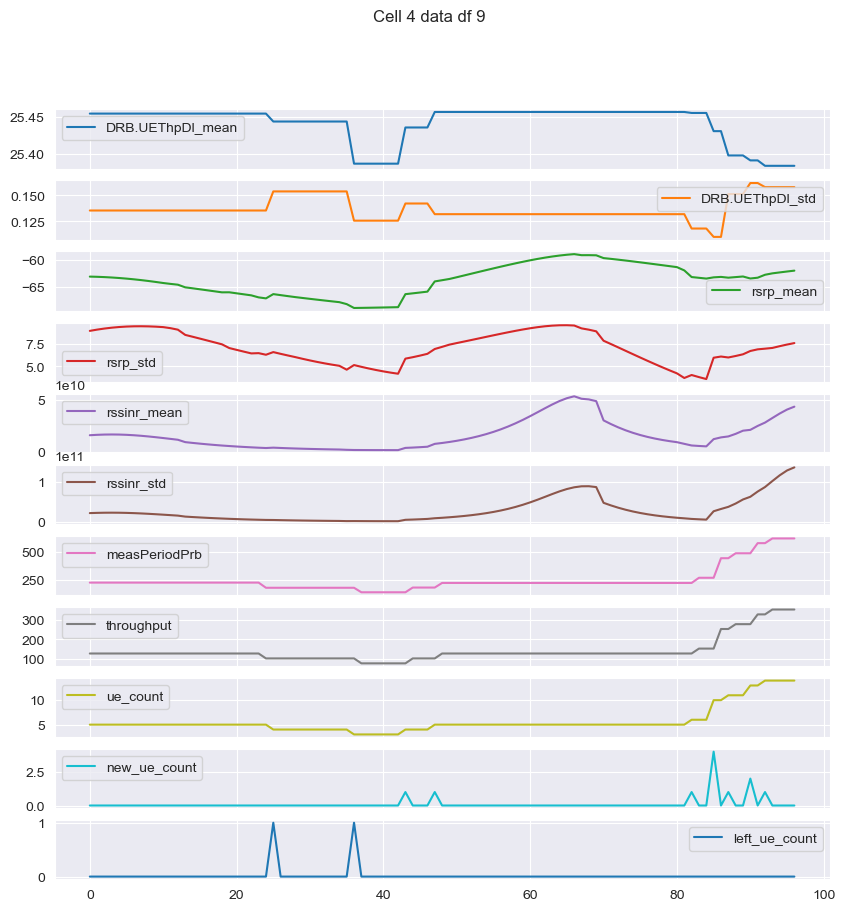

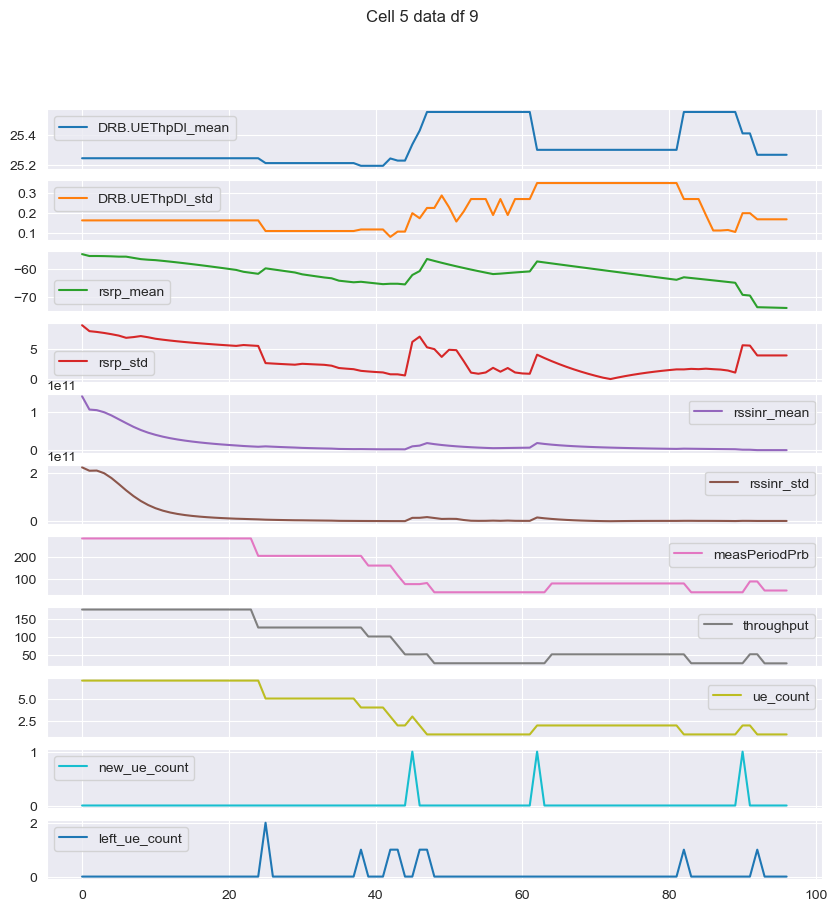

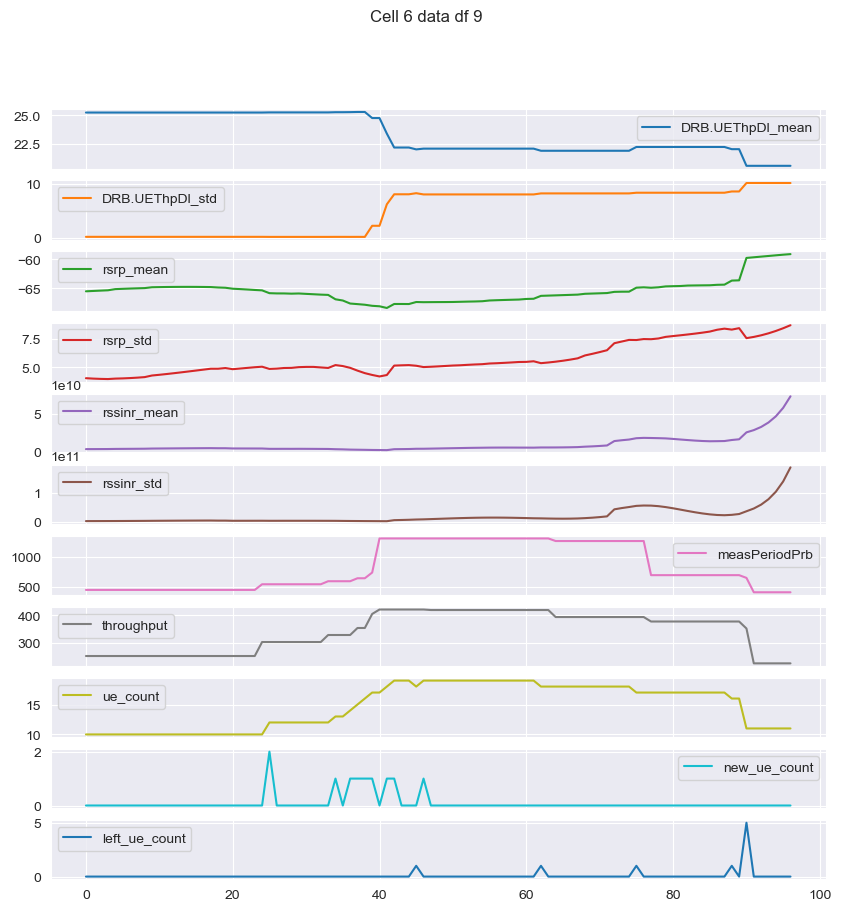

In [256]:
for j, d in enumerate(feats):
    for i in range(1, 7):
        plot_data(d, i, j)